In [1]:
import numpy as np
import pandas as pd
import adjustText
import hdbscan
import subprocess
from os.path import isfile
import seaborn as sns
import scipy.sparse as ss
from sklearn.manifold import TSNE
from sklearn.utils import check_array
from sklearn.base import BaseEstimator
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

import bokeh
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, value, CustomJS
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import plasma
from collections import OrderedDict

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec


# %matplotlib inline
sns.set_context('poster')
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
# from ipywidgets import interact_manual, fixed, Text

In [3]:
raw_data = pd.read_csv('subreddit-overlap.csv')

In [4]:
raw_data

t1_subreddit          t2_subreddit  NumOverlaps
0                  roblox        spaceengineers           20
1                 madlads                Guitar           29
2                Chargers            BigBrother           29
3           NetflixBestOf             celebnsfw           35
4                JoeRogan  Glitch_in_the_Matrix           28
...                   ...                   ...          ...
15381945      videography  Political_Revolution           15
15381946       fireemblem            dyinglight           15
15381947      DataHoarder                   RBI           15
15381948         undelete           NewYorkMets           15
15381949  fantasybaseball                  lost           15

[15381950 rows x 3 columns]

In [5]:
len(raw_data["t1_subreddit"].unique())

2103

In [6]:
len(raw_data["t2_subreddit"].unique())

56187

In [7]:
subreddit_popularity = raw_data.groupby('t2_subreddit')['NumOverlaps'].sum()
subreddits = np.array(subreddit_popularity.sort_values(ascending=False).index)

In [8]:
subreddit_popularity

t2_subreddit
007ReadAlong       2
00sRock           12
00sdesign         14
07Scape           33
0MAGICK         1569
                ... 
zxspectrum       204
zyn               22
zyramains        609
zyzz            2201
zzt                4
Name: NumOverlaps, Length: 56187, dtype: int64

In [9]:
index_map = dict(np.vstack([subreddits, np.arange(subreddits.shape[0])]).T)

In [10]:
count_matrix = ss.coo_matrix((raw_data.NumOverlaps, 
                              (raw_data.t2_subreddit.map(index_map),
                               raw_data.t1_subreddit.map(index_map))),
                             shape=(subreddits.shape[0], subreddits.shape[0]),
                             dtype=np.float64)

In [11]:
conditional_prob_matrix = count_matrix.tocsr()
conditional_prob_matrix = normalize(conditional_prob_matrix, norm='l1', copy=False)

## Converting subreddit vectors into a map

In [12]:
reduced_vectors = TruncatedSVD(n_components=500, random_state=1).fit_transform(conditional_prob_matrix)
reduced_vectors = normalize(reduced_vectors, norm='l2', copy=False)

In [13]:
reduced_vectors.shape

(56187, 500)

In [14]:
tsne = TSNE(verbose=1, n_components=2, perplexity=50)

subreddit_map = tsne.fit_transform(reduced_vectors[:10000])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.297s...
[t-SNE] Computed neighbors for 10000 samples in 102.491s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.503571
[t-SNE] KL divergence after 1000 iterations: 1.353376


In [15]:
subreddit_map_df = pd.DataFrame(subreddit_map, columns=('x', 'y'))
subreddit_map_df['subreddit'] = subreddits[:10000]
subreddit_map_df.head()

x         y      subreddit
0 -21.652040  4.258343      AskReddit
1 -21.625256  4.501749           pics
2 -21.579210  4.242323          funny
3 -21.767216  5.096743  todayilearned
4 -22.106125  6.949585      worldnews

## Clustering the map

In [16]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=20).fit(subreddit_map)
cluster_ids = clusterer.labels_

In [17]:
subreddit_map_df['cluster'] = cluster_ids

## Visualization

In [18]:
output_notebook()
# To output to a static html file, comment out the previous
# line, and uncomment the line below.
# output_file('subreddit_interactive_map.html')

Loading BokehJS ...

In [53]:
# Construct a color palette and map clusters to colors
palette = ['#777777'] + list(plasma(cluster_ids.max()))

colormap = LinearColorMapper(palette=palette, low=-1, high=cluster_ids.max())

color_dict = {
    'field': 'cluster', 
    'transform': colormap
}

# Set fill alpha globally
subreddit_map_df['fill_alpha'] = np.exp((subreddit_map.min() - subreddit_map.max()) / 5.0) + 0.05

# Build a column data source
plot_data = ColumnDataSource(subreddit_map_df)

# Custom callback for alpha adjustment
jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    alpha = data['fill_alpha']
    for (i = 0; i < alpha.length; i++) {
         alpha[i] = Math.exp((start - end) / 5.0) + 0.05;
    }
    source.trigger('change');
"""

# Create the figure and add tools
fig = figure(
    title='A Map of Subreddits',
    plot_width = 900,
    plot_height = 900,
    tools= ('pan, wheel_zoom, box_zoom,''box_select, reset'),
    active_scroll=u'wheel_zoom'
)

# tools= ('pan, wheel_zoom, box_zoom,''box_select, resize, reset'),
fig.add_tools(
    HoverTool(
        tooltips = OrderedDict(
            [('subreddit', '@subreddit'), ('cluster', '@cluster')]
        )
    )
)

# draw the subreddits as circles on the plot
fig.circle(
    u'x', u'y', 
    source = plot_data,
    fill_color = color_dict, 
    line_color = None, 
    fill_alpha = 'fill_alpha',
    size = 10, 
    hover_line_color = u'black'
)

callback = CustomJS(
    args=dict(
        source=plot_data,
    ), 
    code=jscode
)

# fig.x_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)
# fig.y_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)

# fig.x_range.js_on_change("plot_data", callback)
# fig.y_range.js_on_change("plot_data", callback)

# configure visual elements of the plot
fig.title.text_font_size = value('18pt')
fig.title.align = 'center'
fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.grid_line_color = None
fig.outline_line_color = '#222222'

# # display the figure
show(fig)

In [20]:
import inspect

In [21]:
# inspect.getmembers(fig)

In [22]:
# inspect.getmembers(fig.x_range)

In [23]:
# inspect.getmembers(callback)

In [24]:
# inspect.getmembers(fig.x_range.js_on_change)

## Exploring the clusters

In [25]:
def cluster_bounds(dataframe, subreddit):
    # Find the cluster the subreddit belongs to
    cluster = dataframe.cluster[
        dataframe.subreddit == subreddit].values[0]
    if cluster == -1:
        warn('This subreddit was lost as noise and not in any cluster')
        
    # Extract the dubset of the dataframe that is the cluster
    sub_dataframe = dataframe[dataframe.cluster == cluster]
    
    x_min = sub_dataframe.x.min()
    x_max = sub_dataframe.x.max()
    x_padding = (x_max - x_min) * 0.5
    x_min -= x_padding
    x_max += x_padding
    
    y_min = sub_dataframe.y.min()
    y_max = sub_dataframe.y.max()
    y_padding = (y_max - y_min) * 0.5
    y_min -= y_padding
    y_max += y_padding

    return x_min, x_max, y_min, y_max

In [26]:
def data_in_bounds(dataframe, bounds):
    return dataframe[
        (dataframe.x > bounds[0]) &
        (dataframe.x < bounds[1]) &
        (dataframe.y > bounds[2]) &
        (dataframe.y < bounds[3])
    ]

In [27]:
def plot_cluster(dataframe, subreddit):
    # Build a color map to match the Bokeh plot
    colormap = dict(zip(
        np.unique(dataframe.cluster),
        ['#777777'] + sns.color_palette('plasma', dataframe.cluster.max() + 1).as_hex()
    ))
    subregion_defined = True
    
    # Figure and gridspec to layout axes
    fig = plt.figure(figsize=(16,10))
    gs = GridSpec(3, 3)
    
    # First axes, spanning most of the figure
    # Contains just the points in a region 
    # around the points in the cluster
    ax1 = plt.subplot(gs[:,:2])
    try:
        bounds = cluster_bounds(dataframe, subreddit)
    except IndexError:
        ax1.text(0.5, 0.5, 'Subreddit {} not found!'.format(subreddit), 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax1.transAxes, fontsize=18)
        subregion_defined = False
    
    if subregion_defined:
        to_plot = data_in_bounds(dataframe, bounds)
        ax1.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.map(colormap), s=30, alpha=0.5)
    
        # We want to add text labels. We subsample up to 50 labels
        # And then use adjustText to get them non-overlapping
        text_elements = []
        for row in to_plot.sample(n=min(len(to_plot),50), random_state=0).values:
            if row[2] != subreddit:
                text_elements.append(ax1.text(row[0], row[1], row[2], alpha=0.5, fontsize=9))
        row = to_plot[to_plot.subreddit == subreddit].values[0]
        text_elements.append(ax1.text(row[0], row[1], row[2], 
                                      color='g',
                                      alpha=0.5, fontsize=11))
        adjustText.adjust_text(text_elements, ax=ax1, lim=100,
                               force_text=0.1, force_points=0.1,
                               arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])

    # Second axes, center right of the figure
    # Plots all the data and a rectangle
    # Showing the area selected out
    ax2 = plt.subplot(gs[1,2])
    ax2.scatter(dataframe.x, dataframe.y, s=20,
                c=dataframe.cluster.map(colormap), alpha=0.05)
    
    if subregion_defined:
        ax2.add_patch(Rectangle(xy=(bounds[0], bounds[2]),
                                    width=(bounds[1] - bounds[0]),
                                    height=(bounds[3] - bounds[2]),
                                    edgecolor='k', facecolor='none', lw=1))
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    plt.tight_layout()

    if subregion_defined:
        # Now we make use of the power of matplotlib transforms
        # to draw line from the subselected rectangle in axes2
        # all the way to the bounds of axes1
        trans_figure = fig.transFigure.inverted()

        ax1_coord = trans_figure.transform(ax1.transAxes.transform((1,0)))
        ax2_coord = trans_figure.transform(ax2.transData.transform((bounds[1],bounds[2])))
        connector1 = Line2D((ax1_coord[0],ax2_coord[0]),(ax1_coord[1],ax2_coord[1]),
                              transform=fig.transFigure, lw=1, color='k')
        ax1_coord = trans_figure.transform(ax1.transAxes.transform((1,1)))
        ax2_coord = trans_figure.transform(ax2.transData.transform((bounds[1],bounds[3])))
        connector2 = Line2D((ax1_coord[0],ax2_coord[0]),(ax1_coord[1],ax2_coord[1]),
                              transform=fig.transFigure, lw=1, color='k')

        fig.lines = [connector1, connector2]

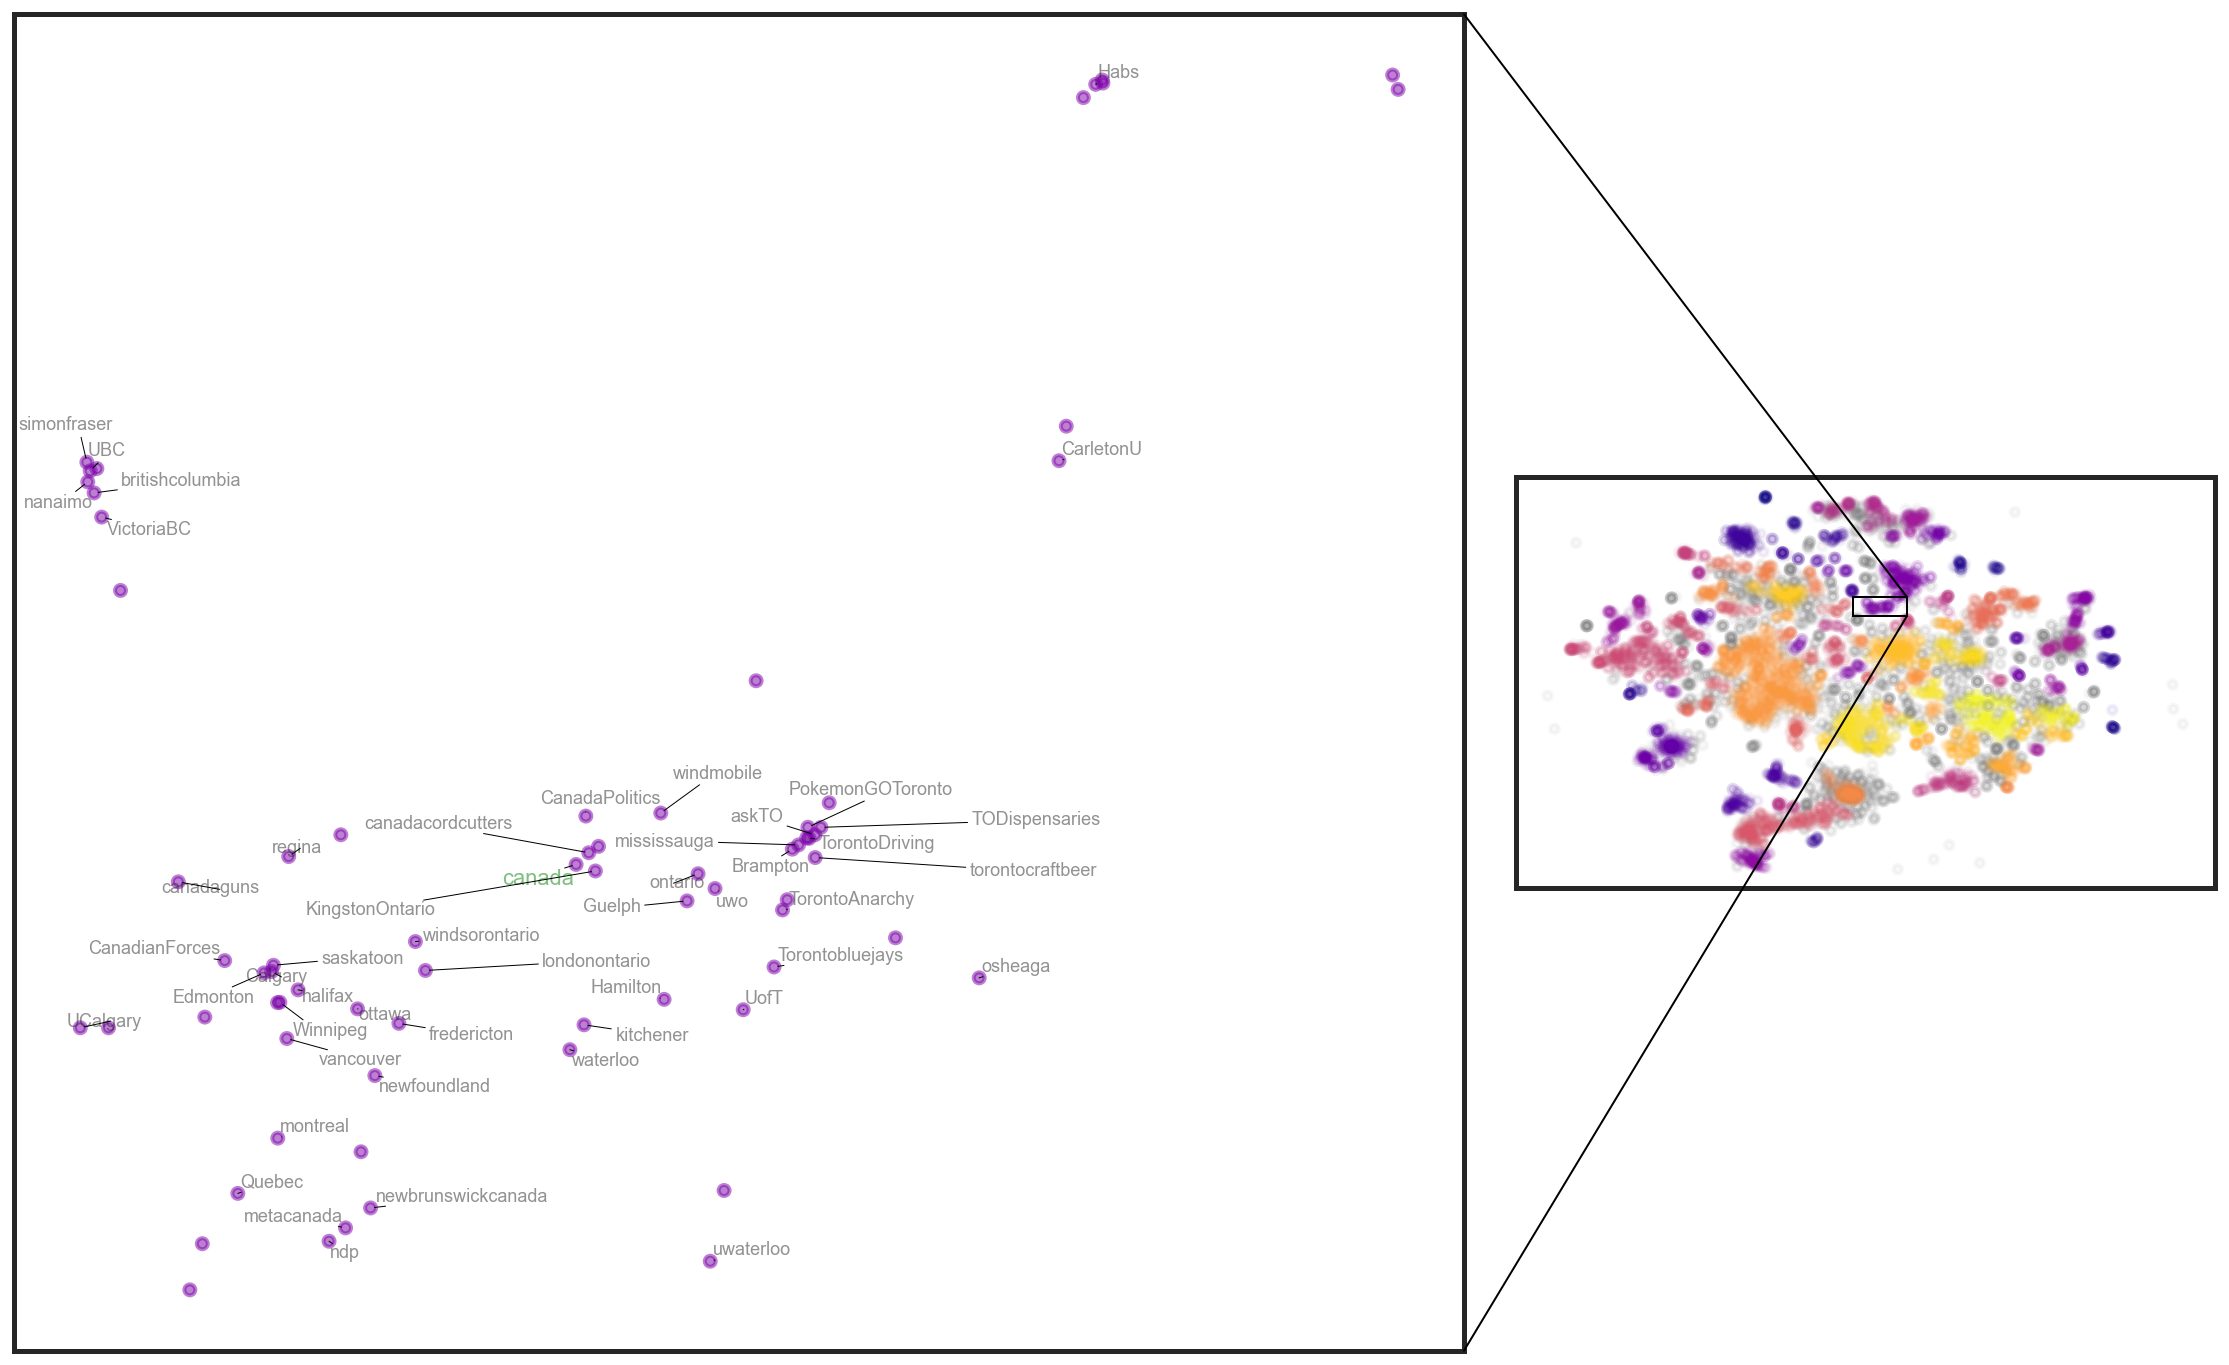

In [28]:
plot_cluster(subreddit_map_df, 'canada')

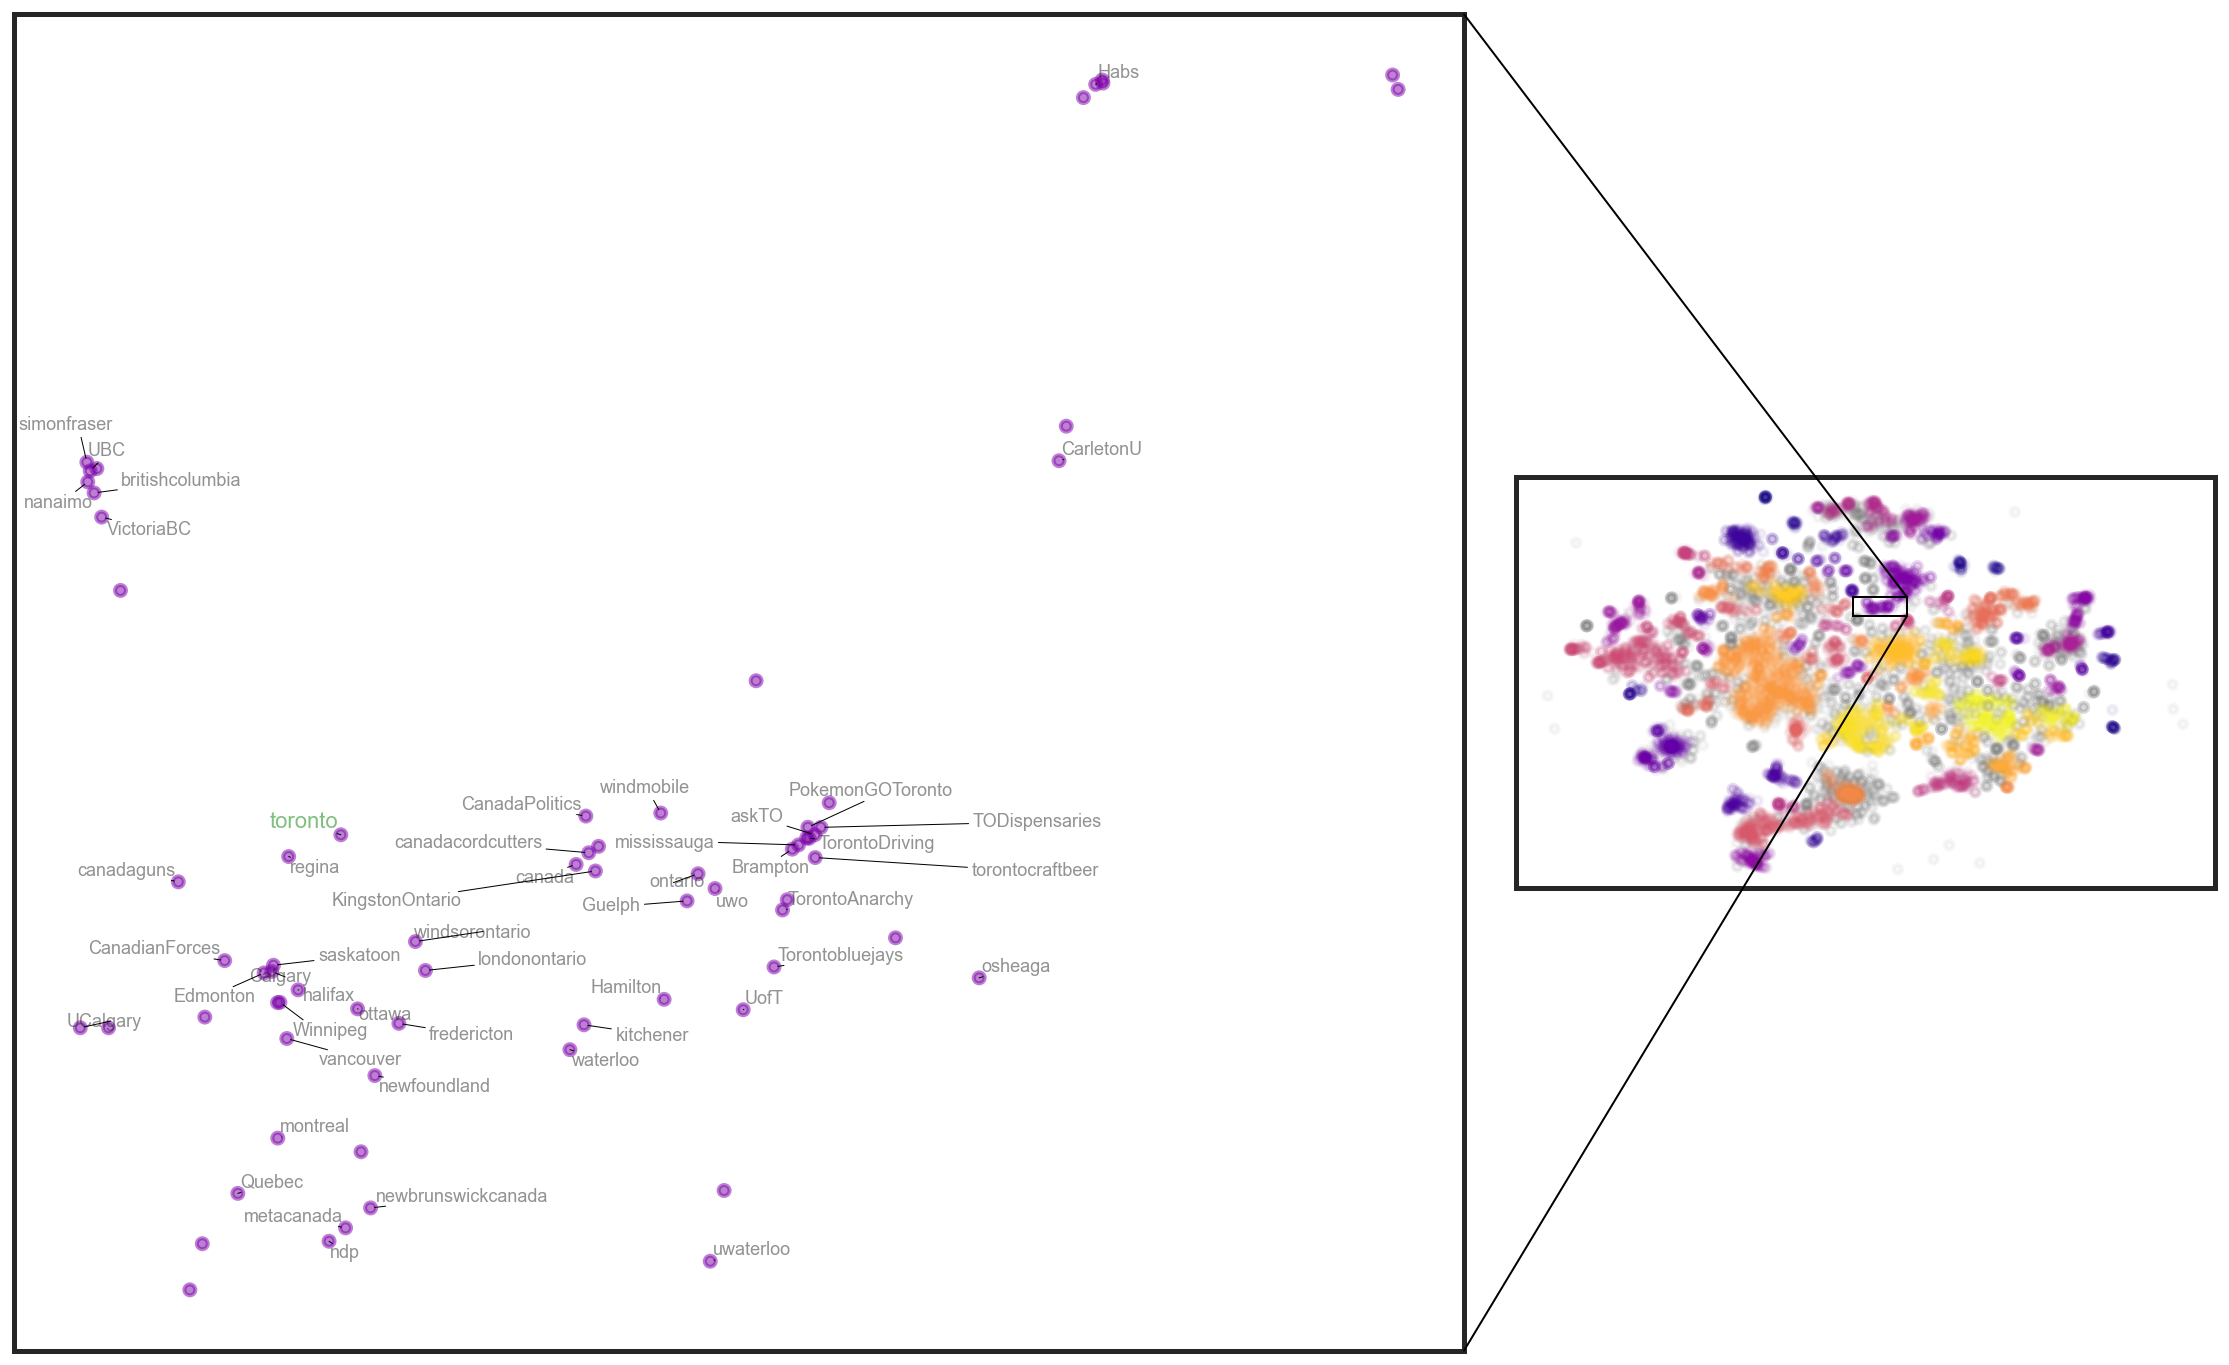

In [29]:
plot_cluster(subreddit_map_df, 'toronto')

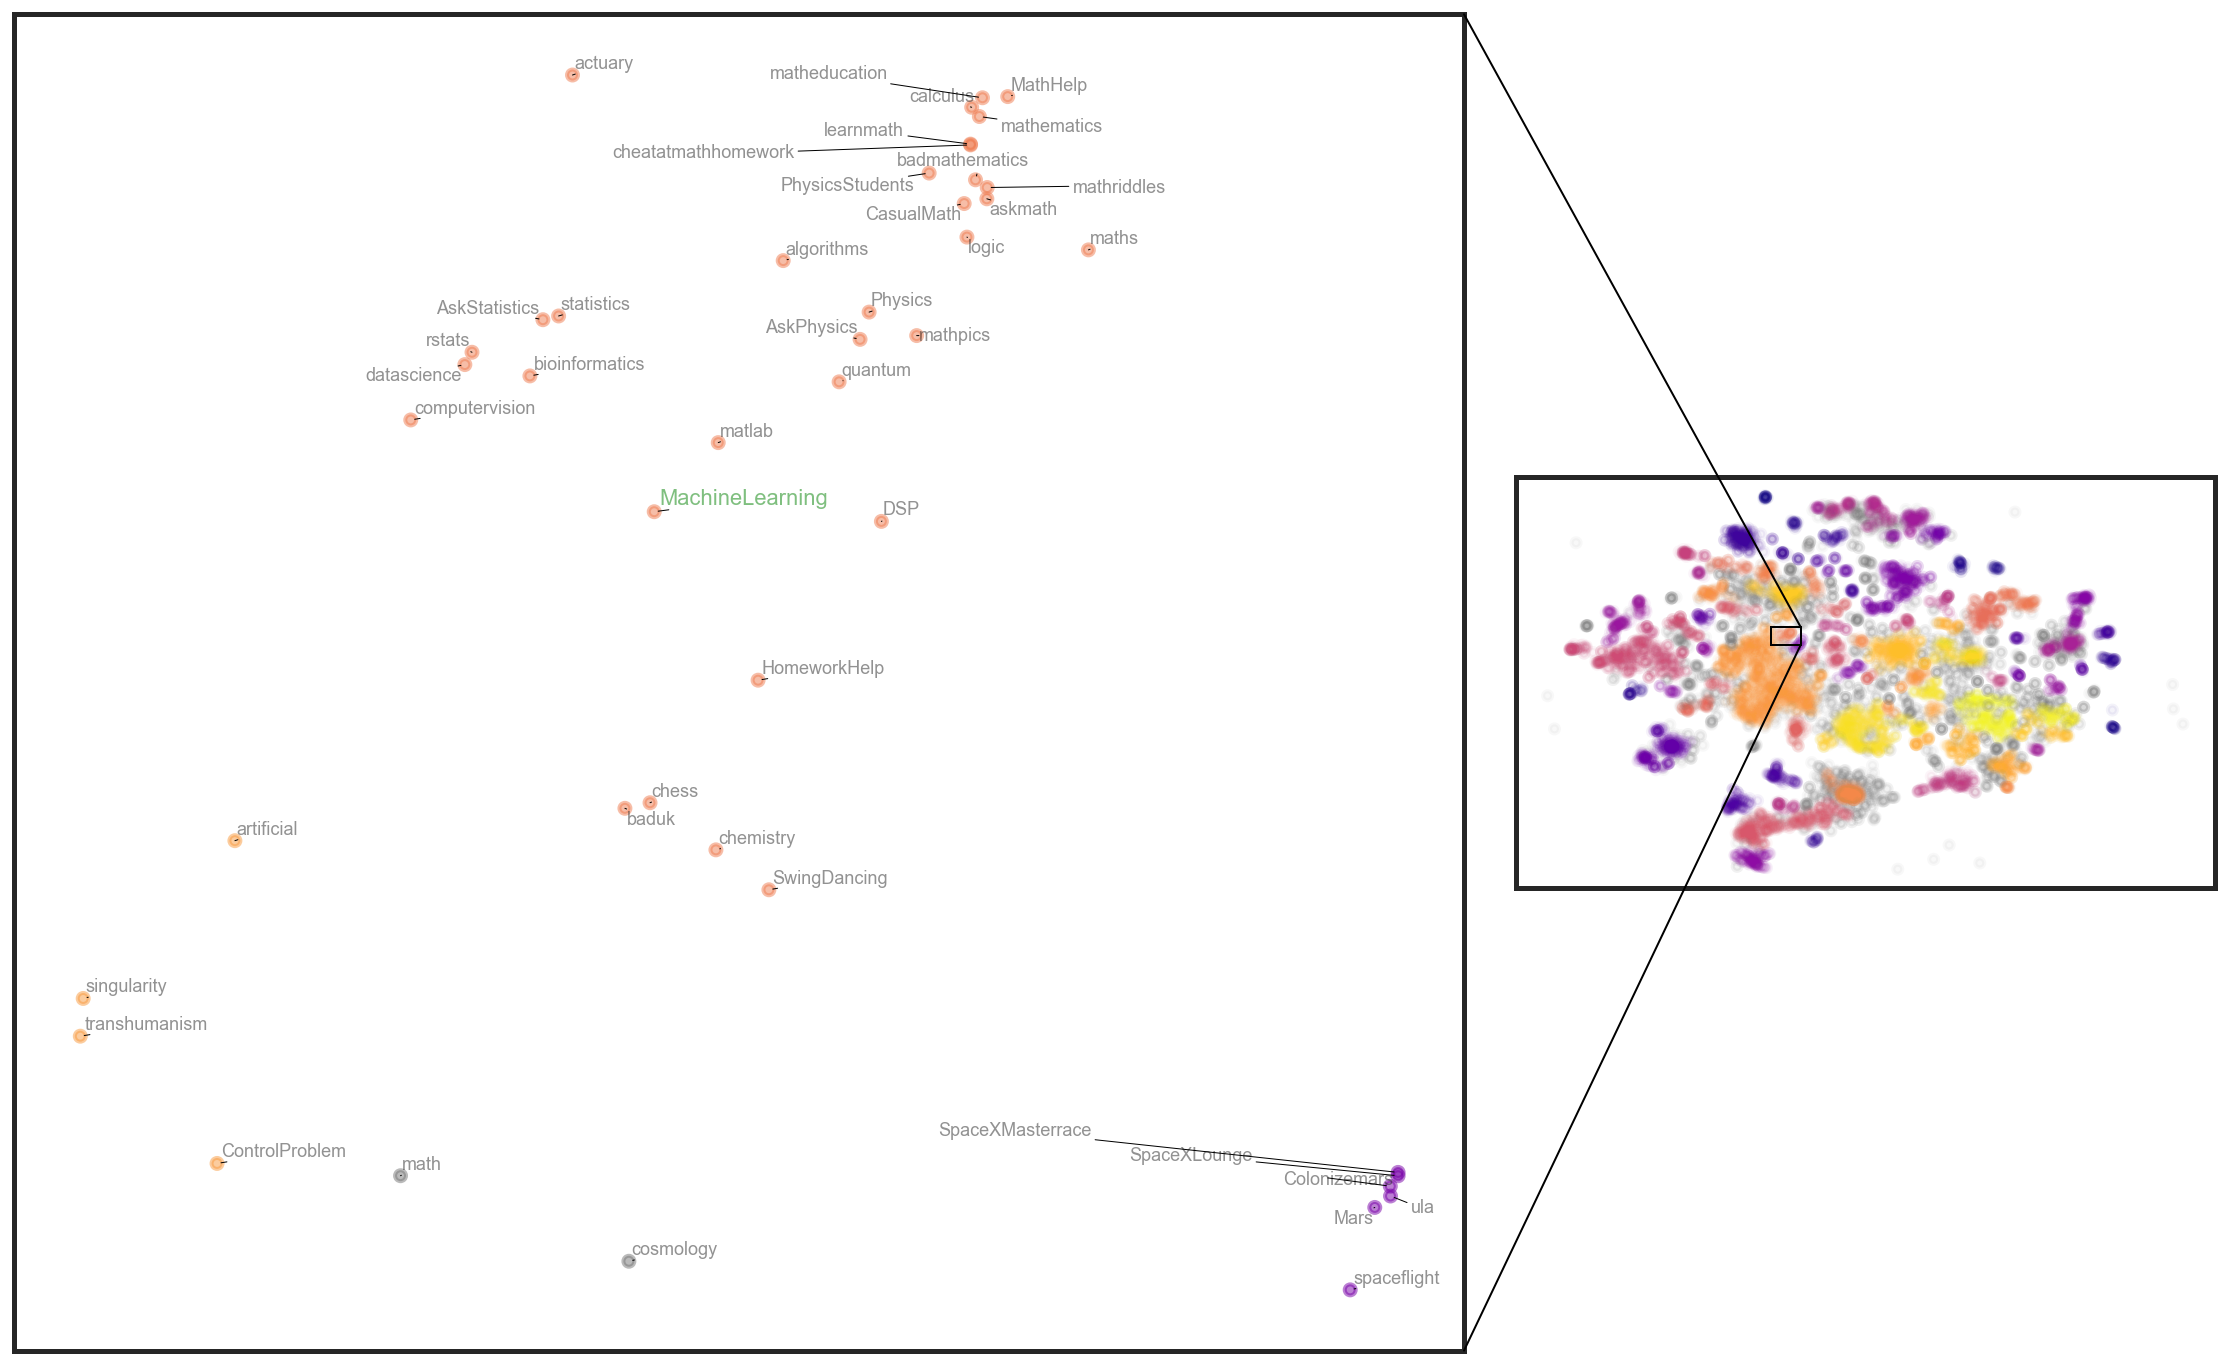

In [30]:
plot_cluster(subreddit_map_df, 'MachineLearning')

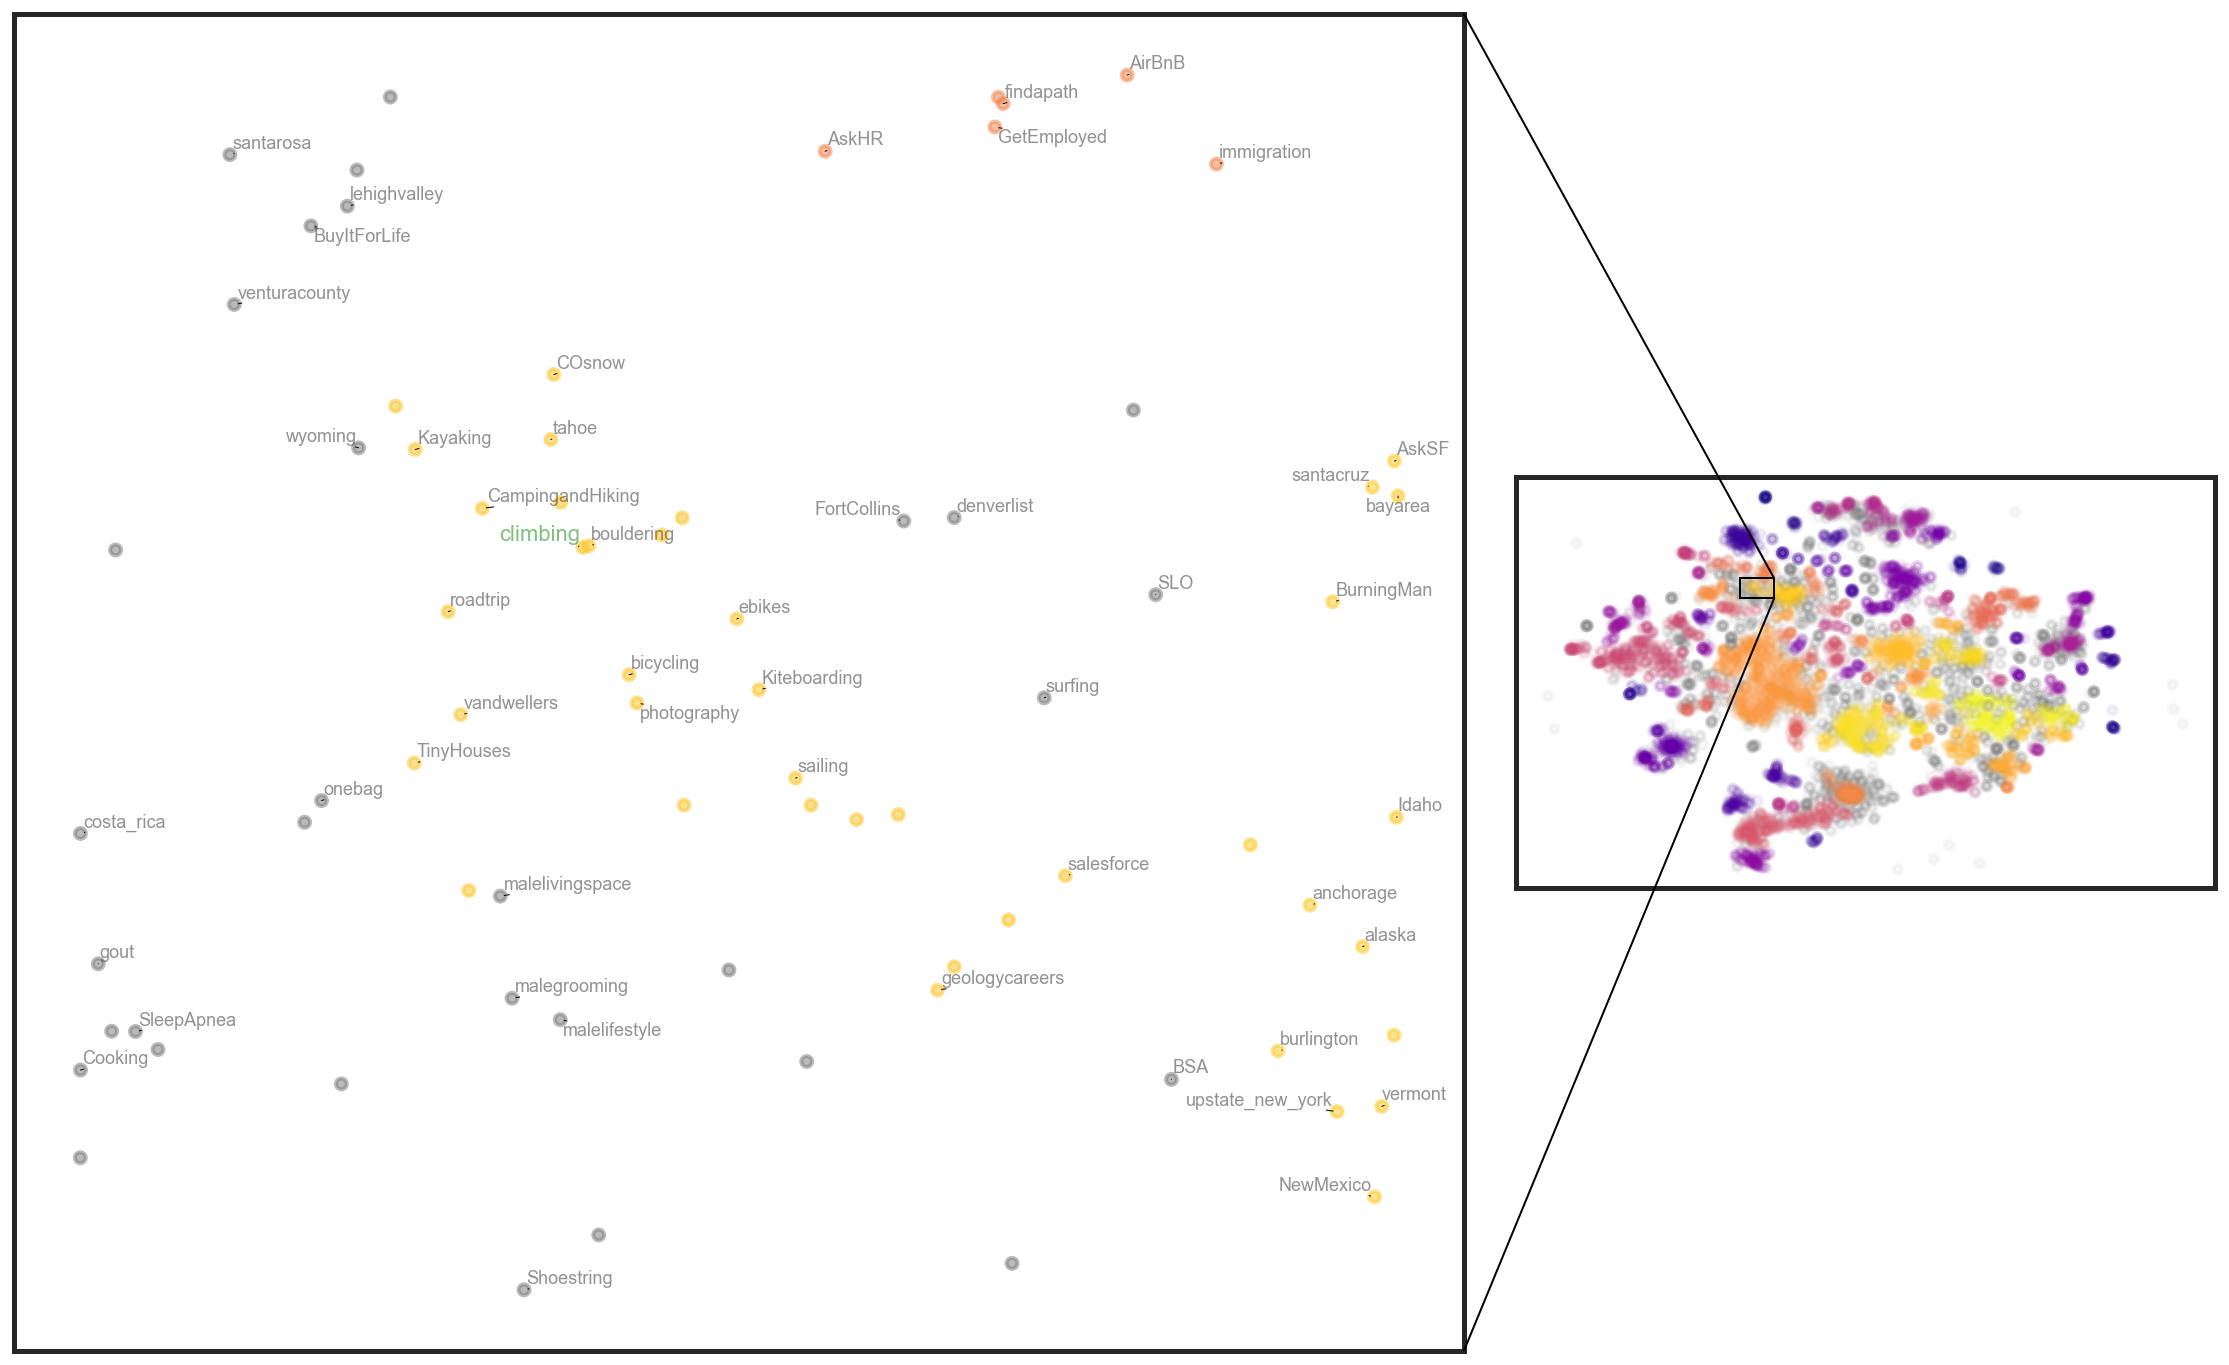

In [31]:
plot_cluster(subreddit_map_df, 'climbing')

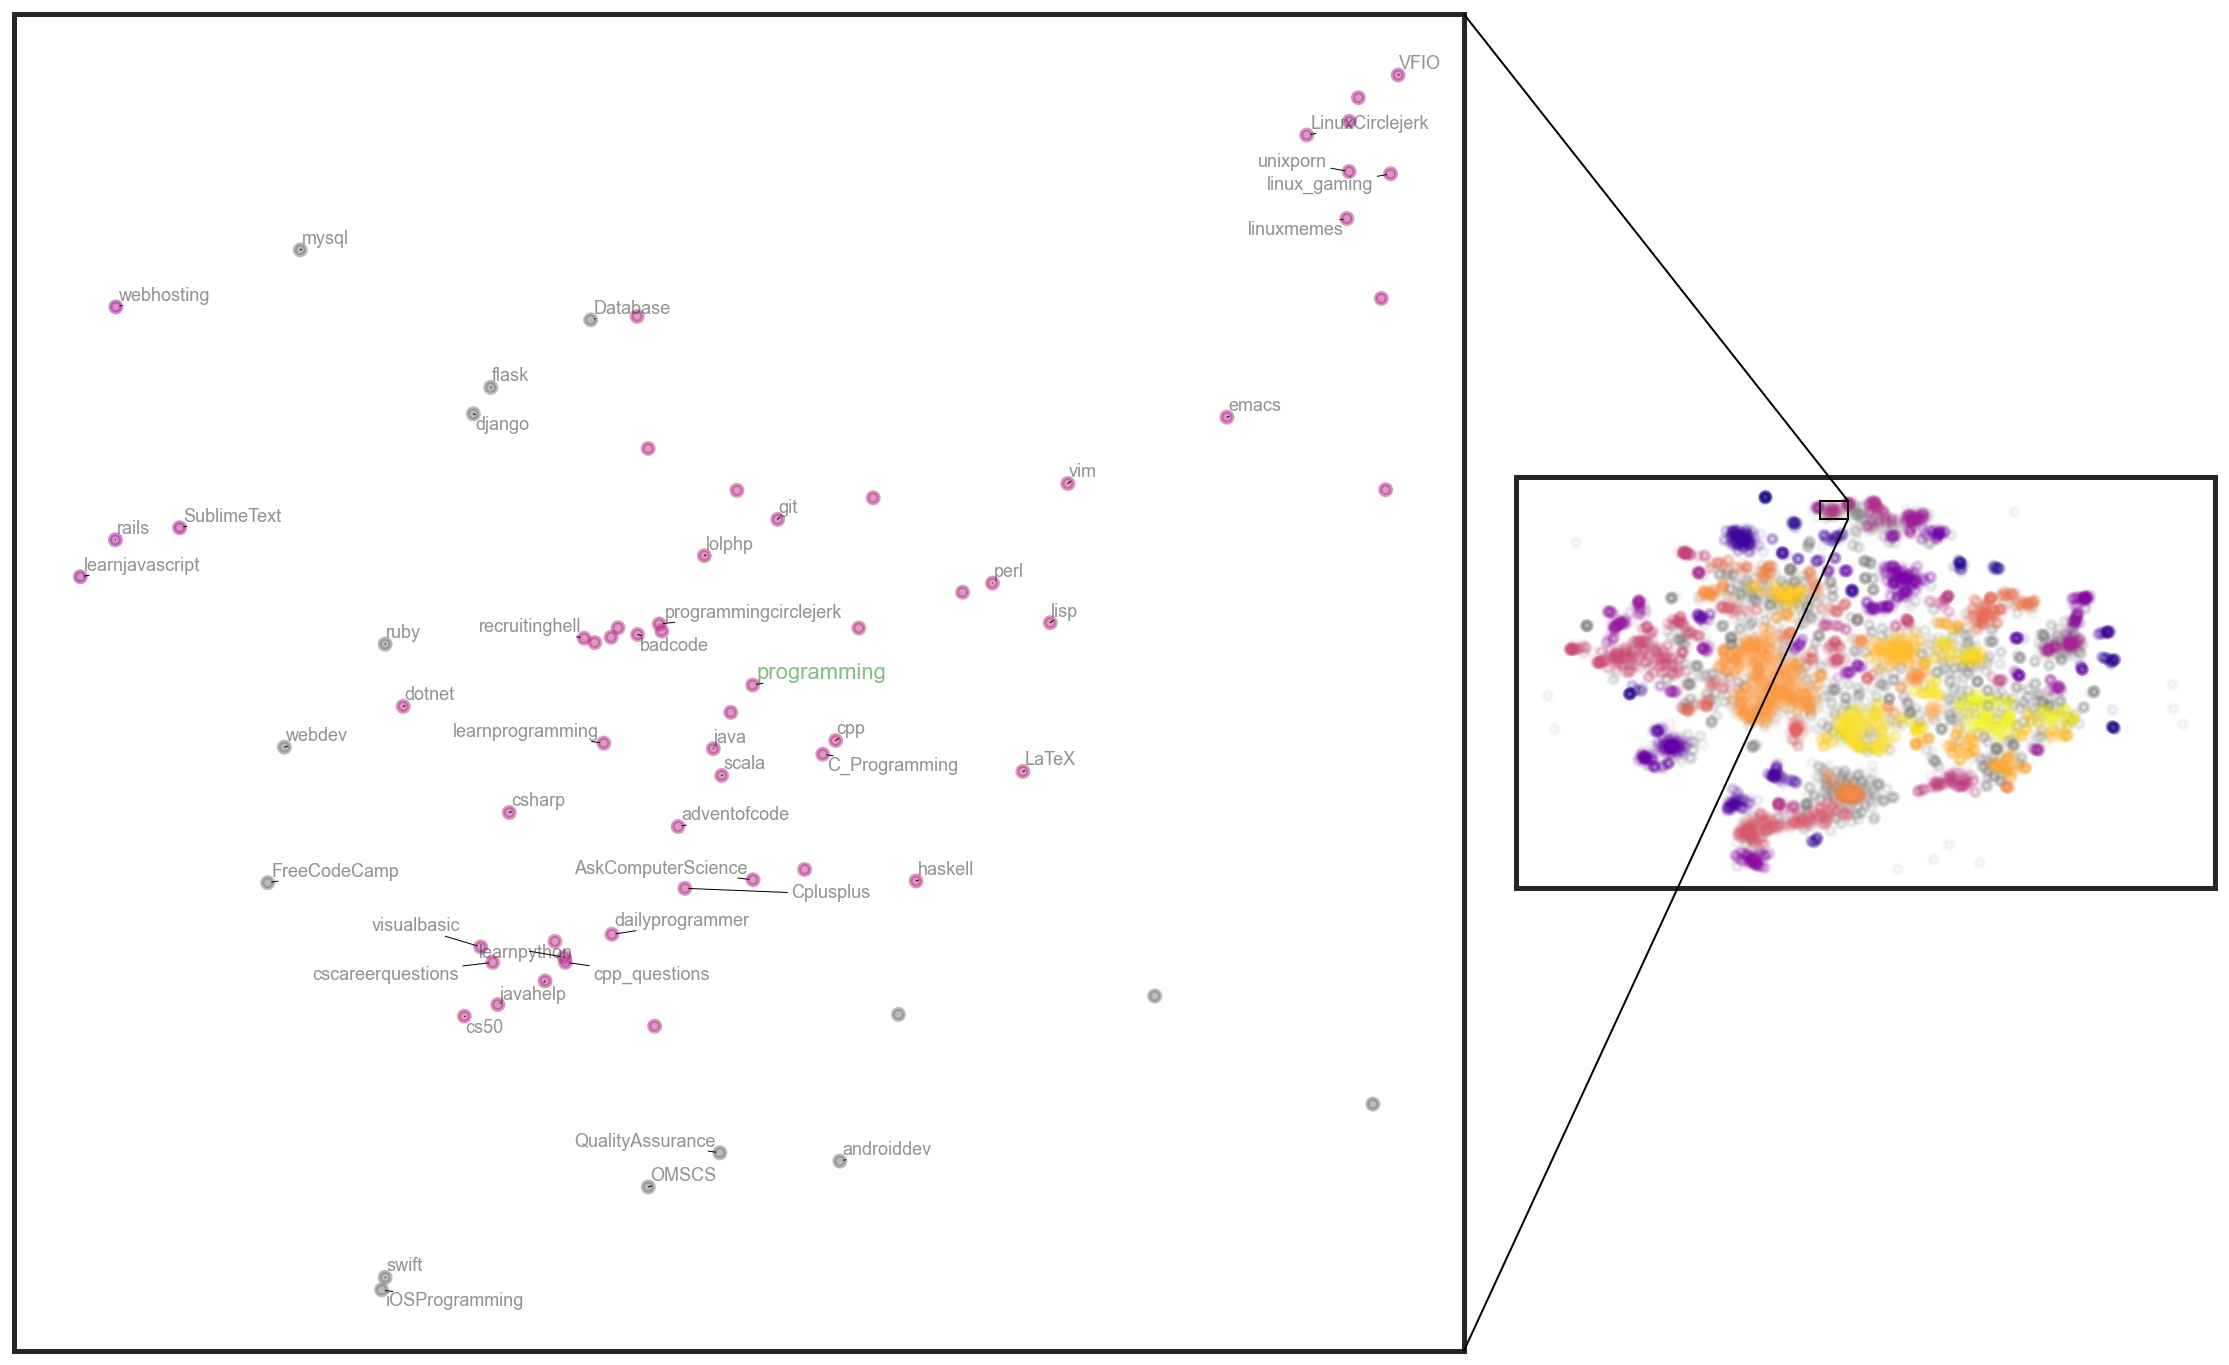

In [32]:
plot_cluster(subreddit_map_df, 'programming')

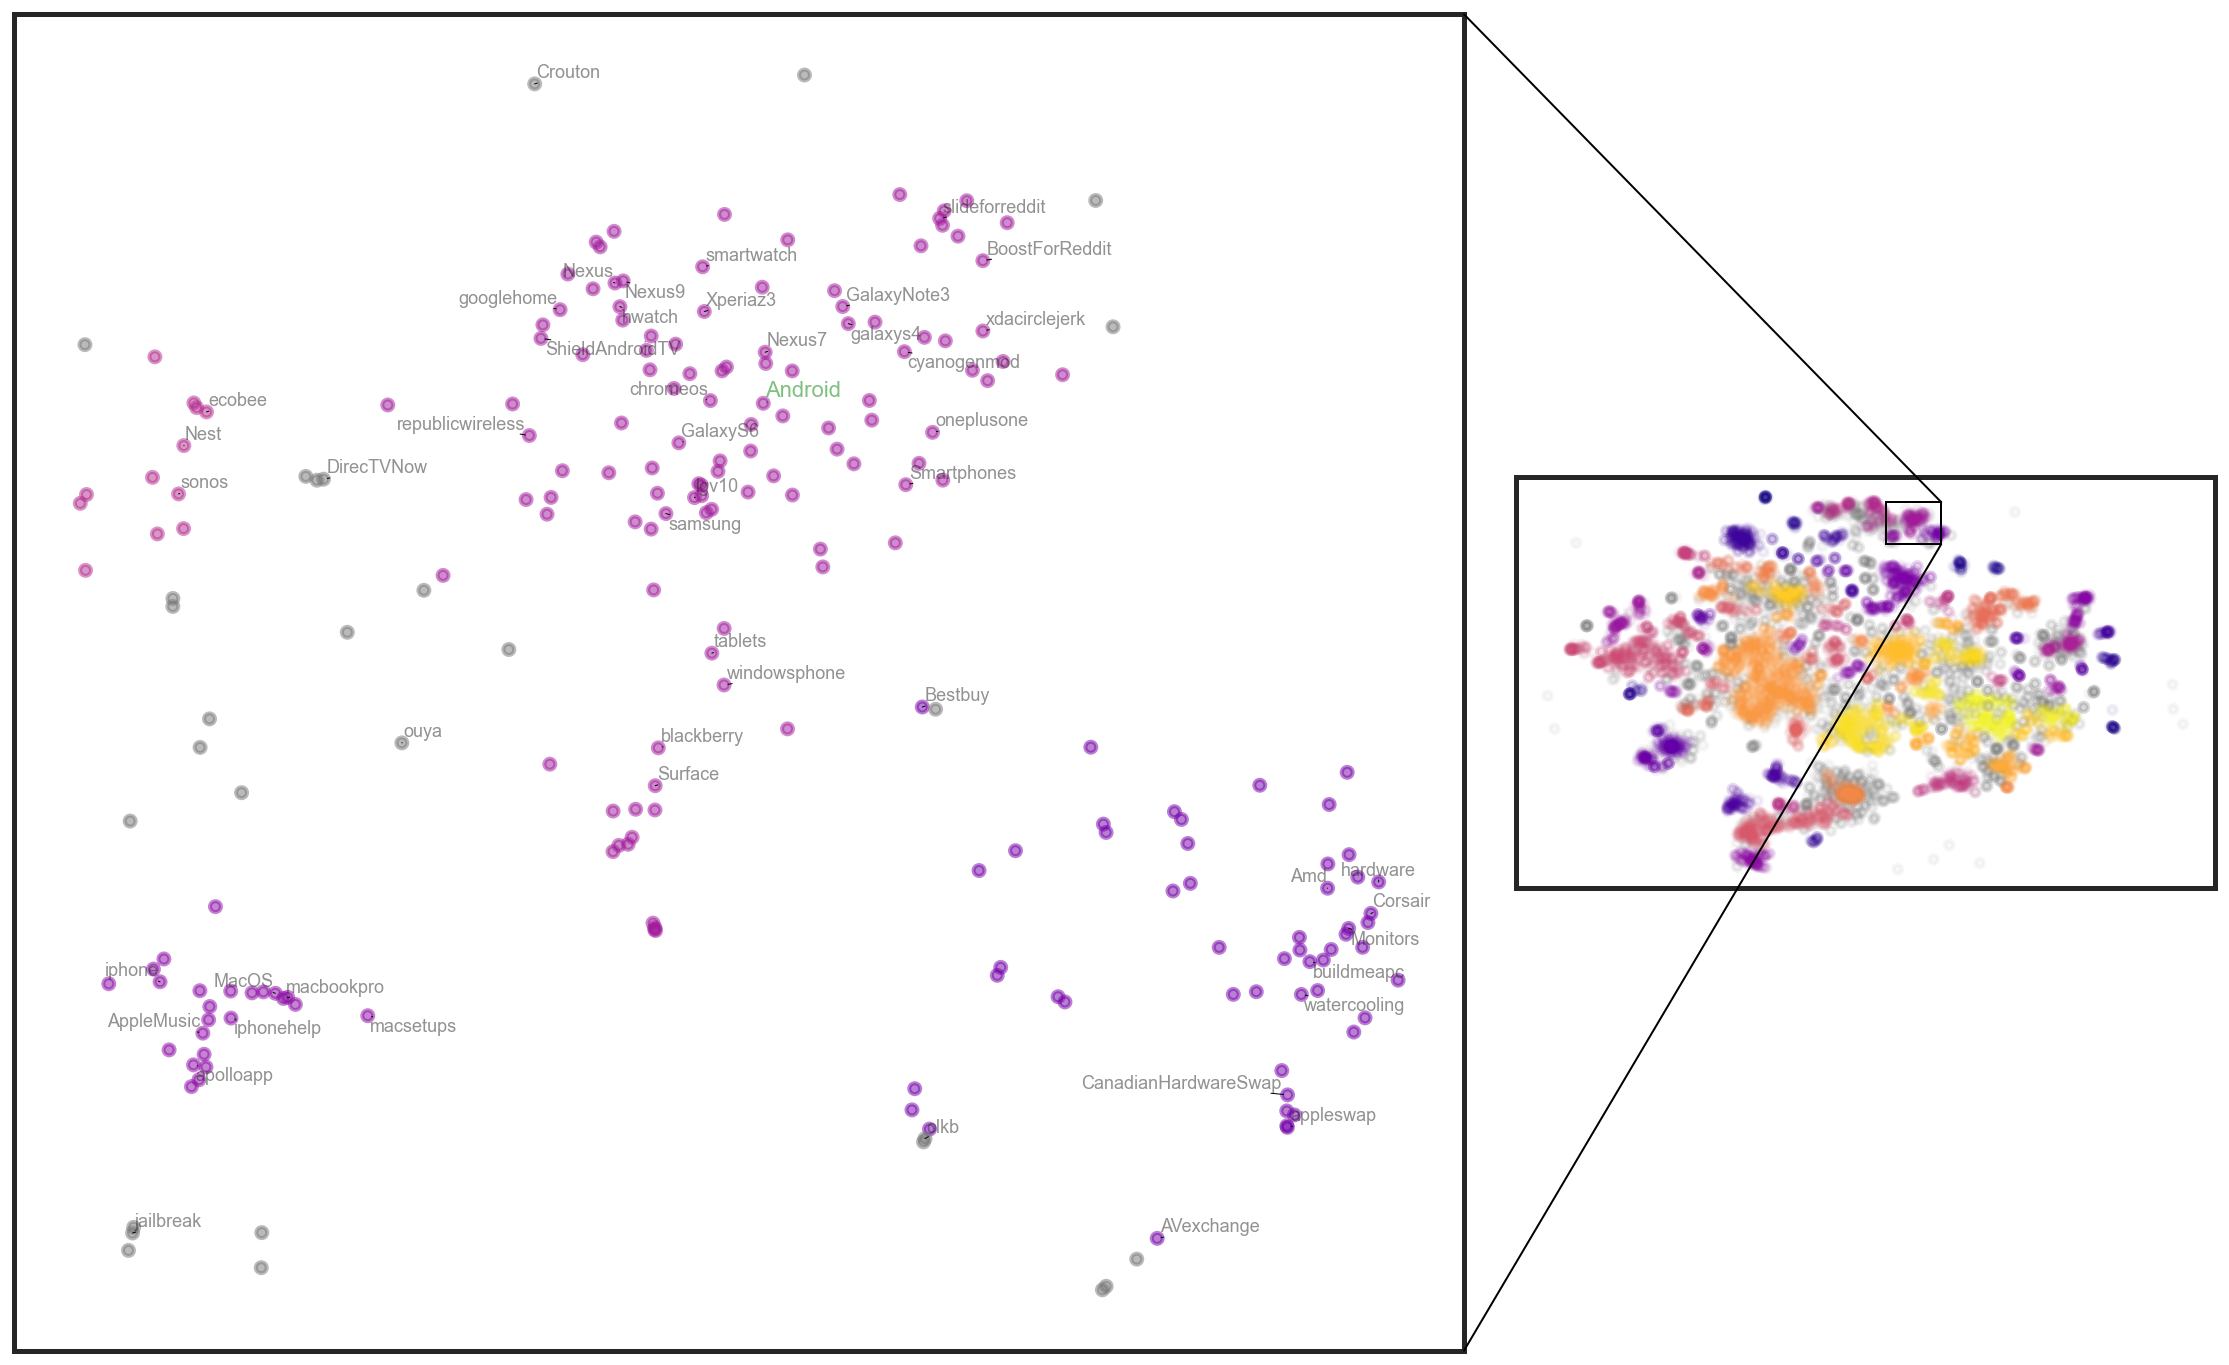

In [33]:
plot_cluster(subreddit_map_df, 'Android')

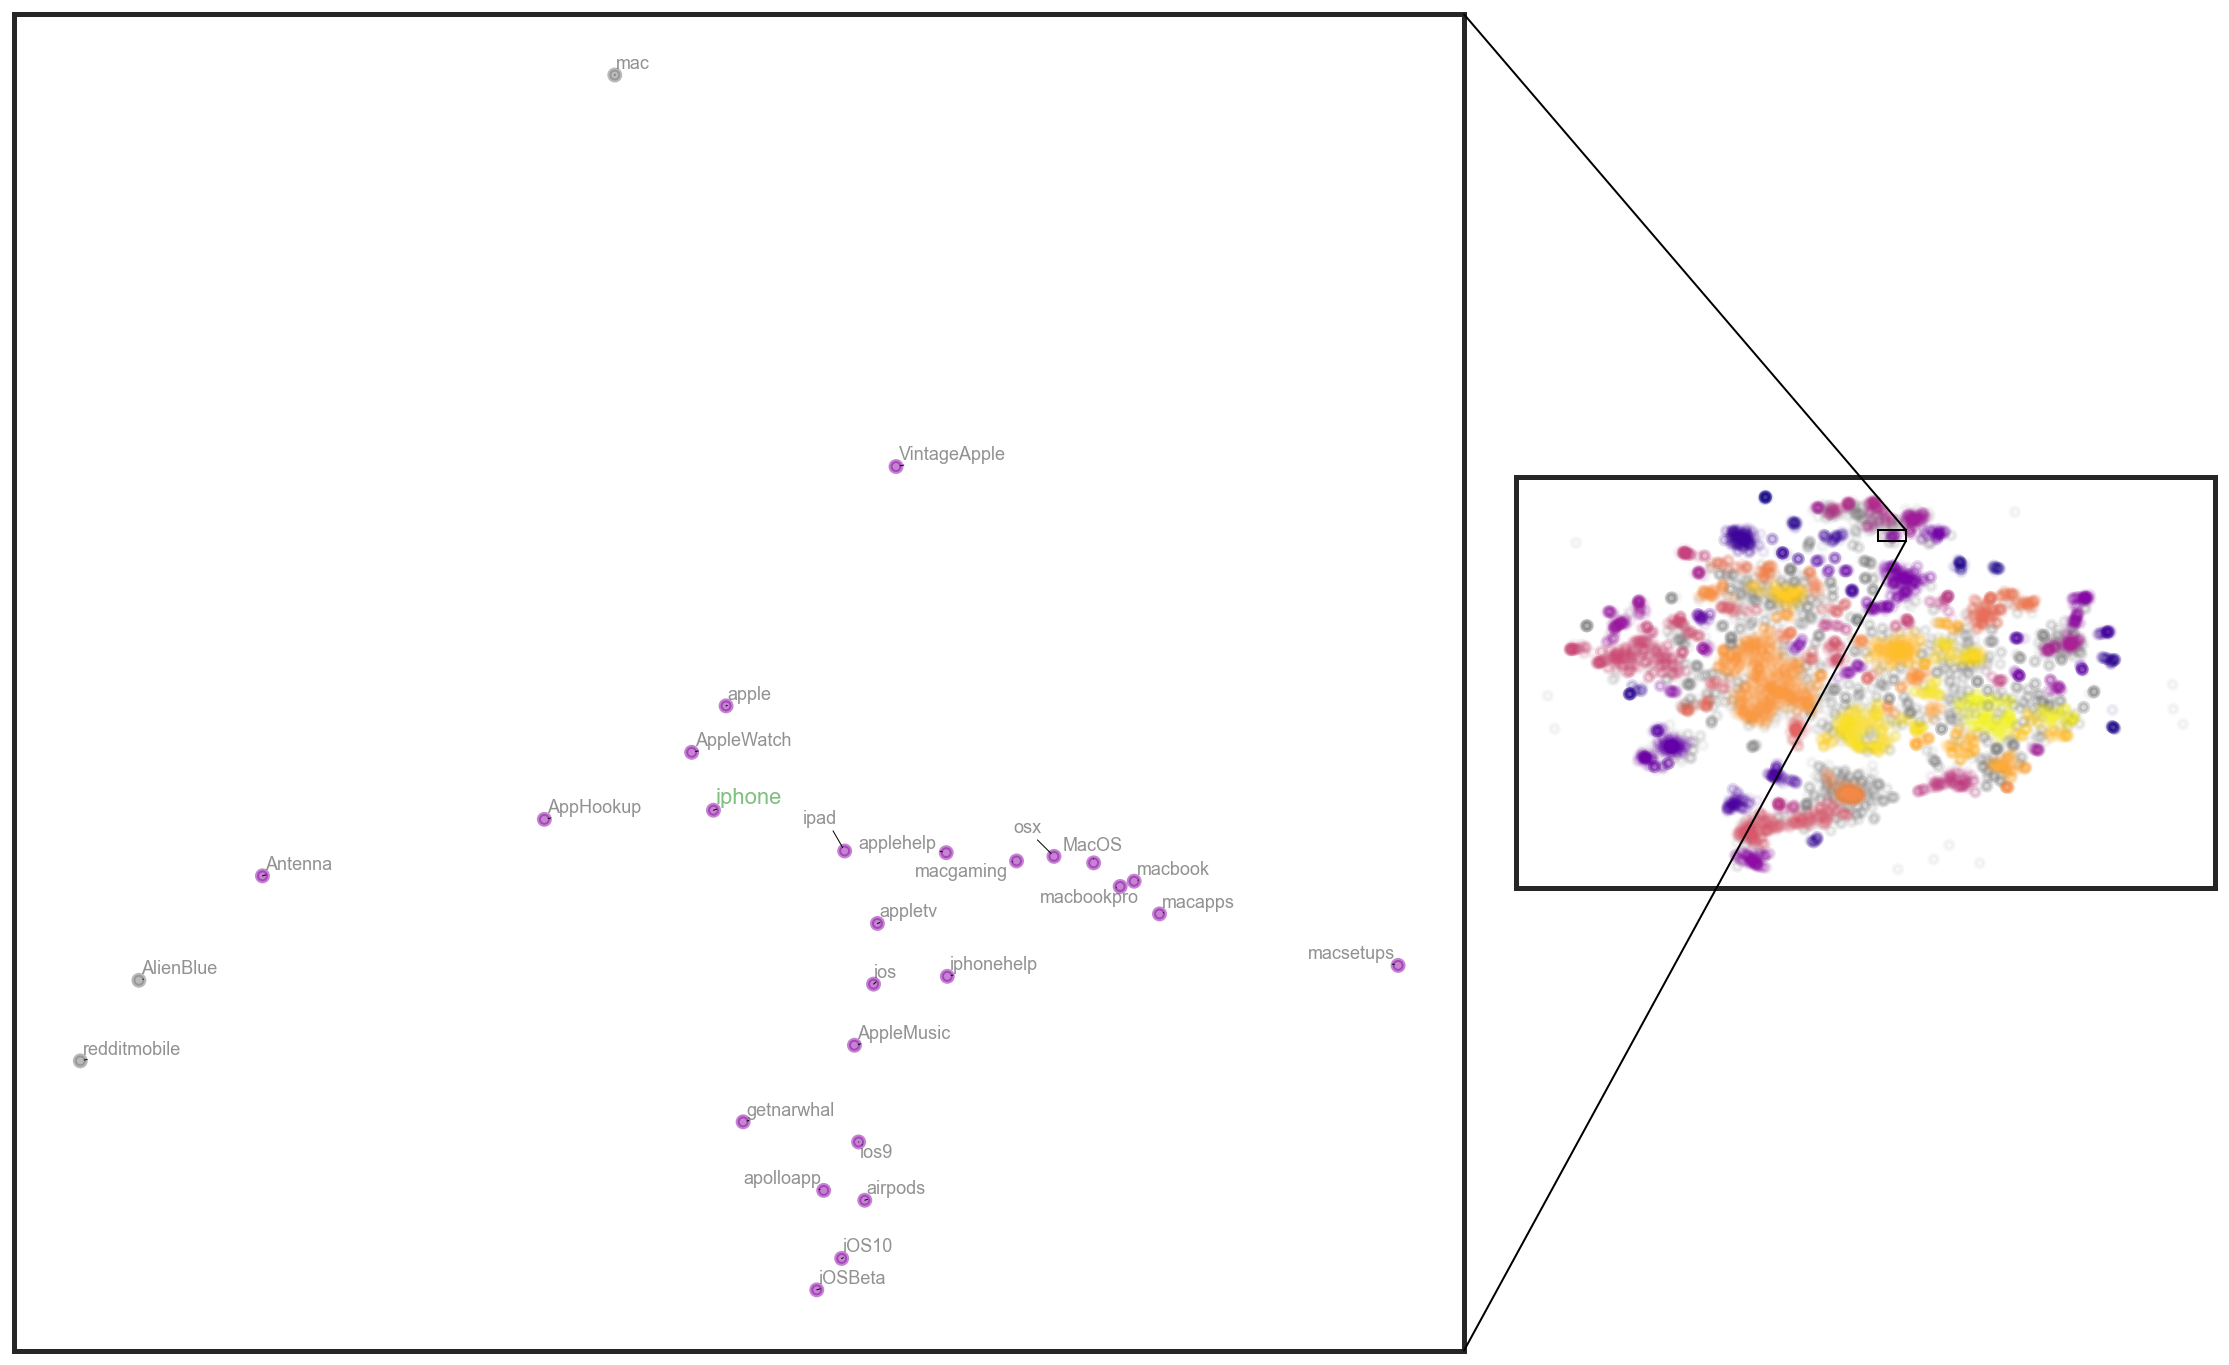

In [34]:
plot_cluster(subreddit_map_df, 'iphone')

In [35]:
from ipywidgets import interact_manual, fixed, Text

In [36]:
interact_manual(plot_cluster, 
                dataframe=fixed(subreddit_map_df), 
                subreddit=Text())

interactive(children=(Text(value='', description='subreddit'), Button(description='Run Interact', style=Button…

<function __main__.plot_cluster(dataframe, subreddit)>

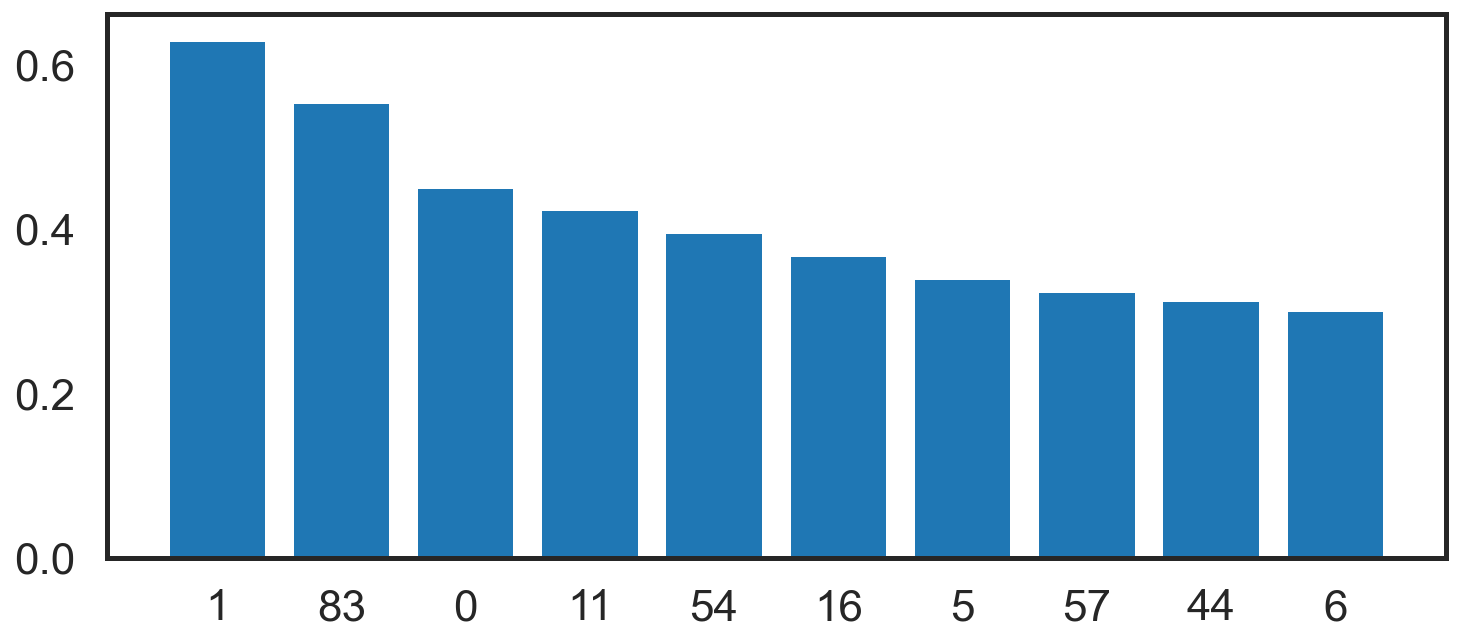

In [37]:
coherent_clusters = np.argsort(clusterer.cluster_persistence_)[-10:][::-1]
coherence = np.sort(clusterer.cluster_persistence_)[-10:][::-1]
fig = plt.figure(figsize=(12,5))
ax = plt.gca()
ax.bar(np.arange(10), coherence)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(coherent_clusters);

In [38]:
def plot_cluster_by_id(dataframe, cluster_id):
    subreddits_in_cluster = np.array(dataframe.subreddit[cluster_ids == cluster_id])
    plot_cluster(dataframe, subreddits_in_cluster[0])
    plt.gcf().text(0.5, 0.98, 'Cluster {}'.format(cluster_id), ha='center')

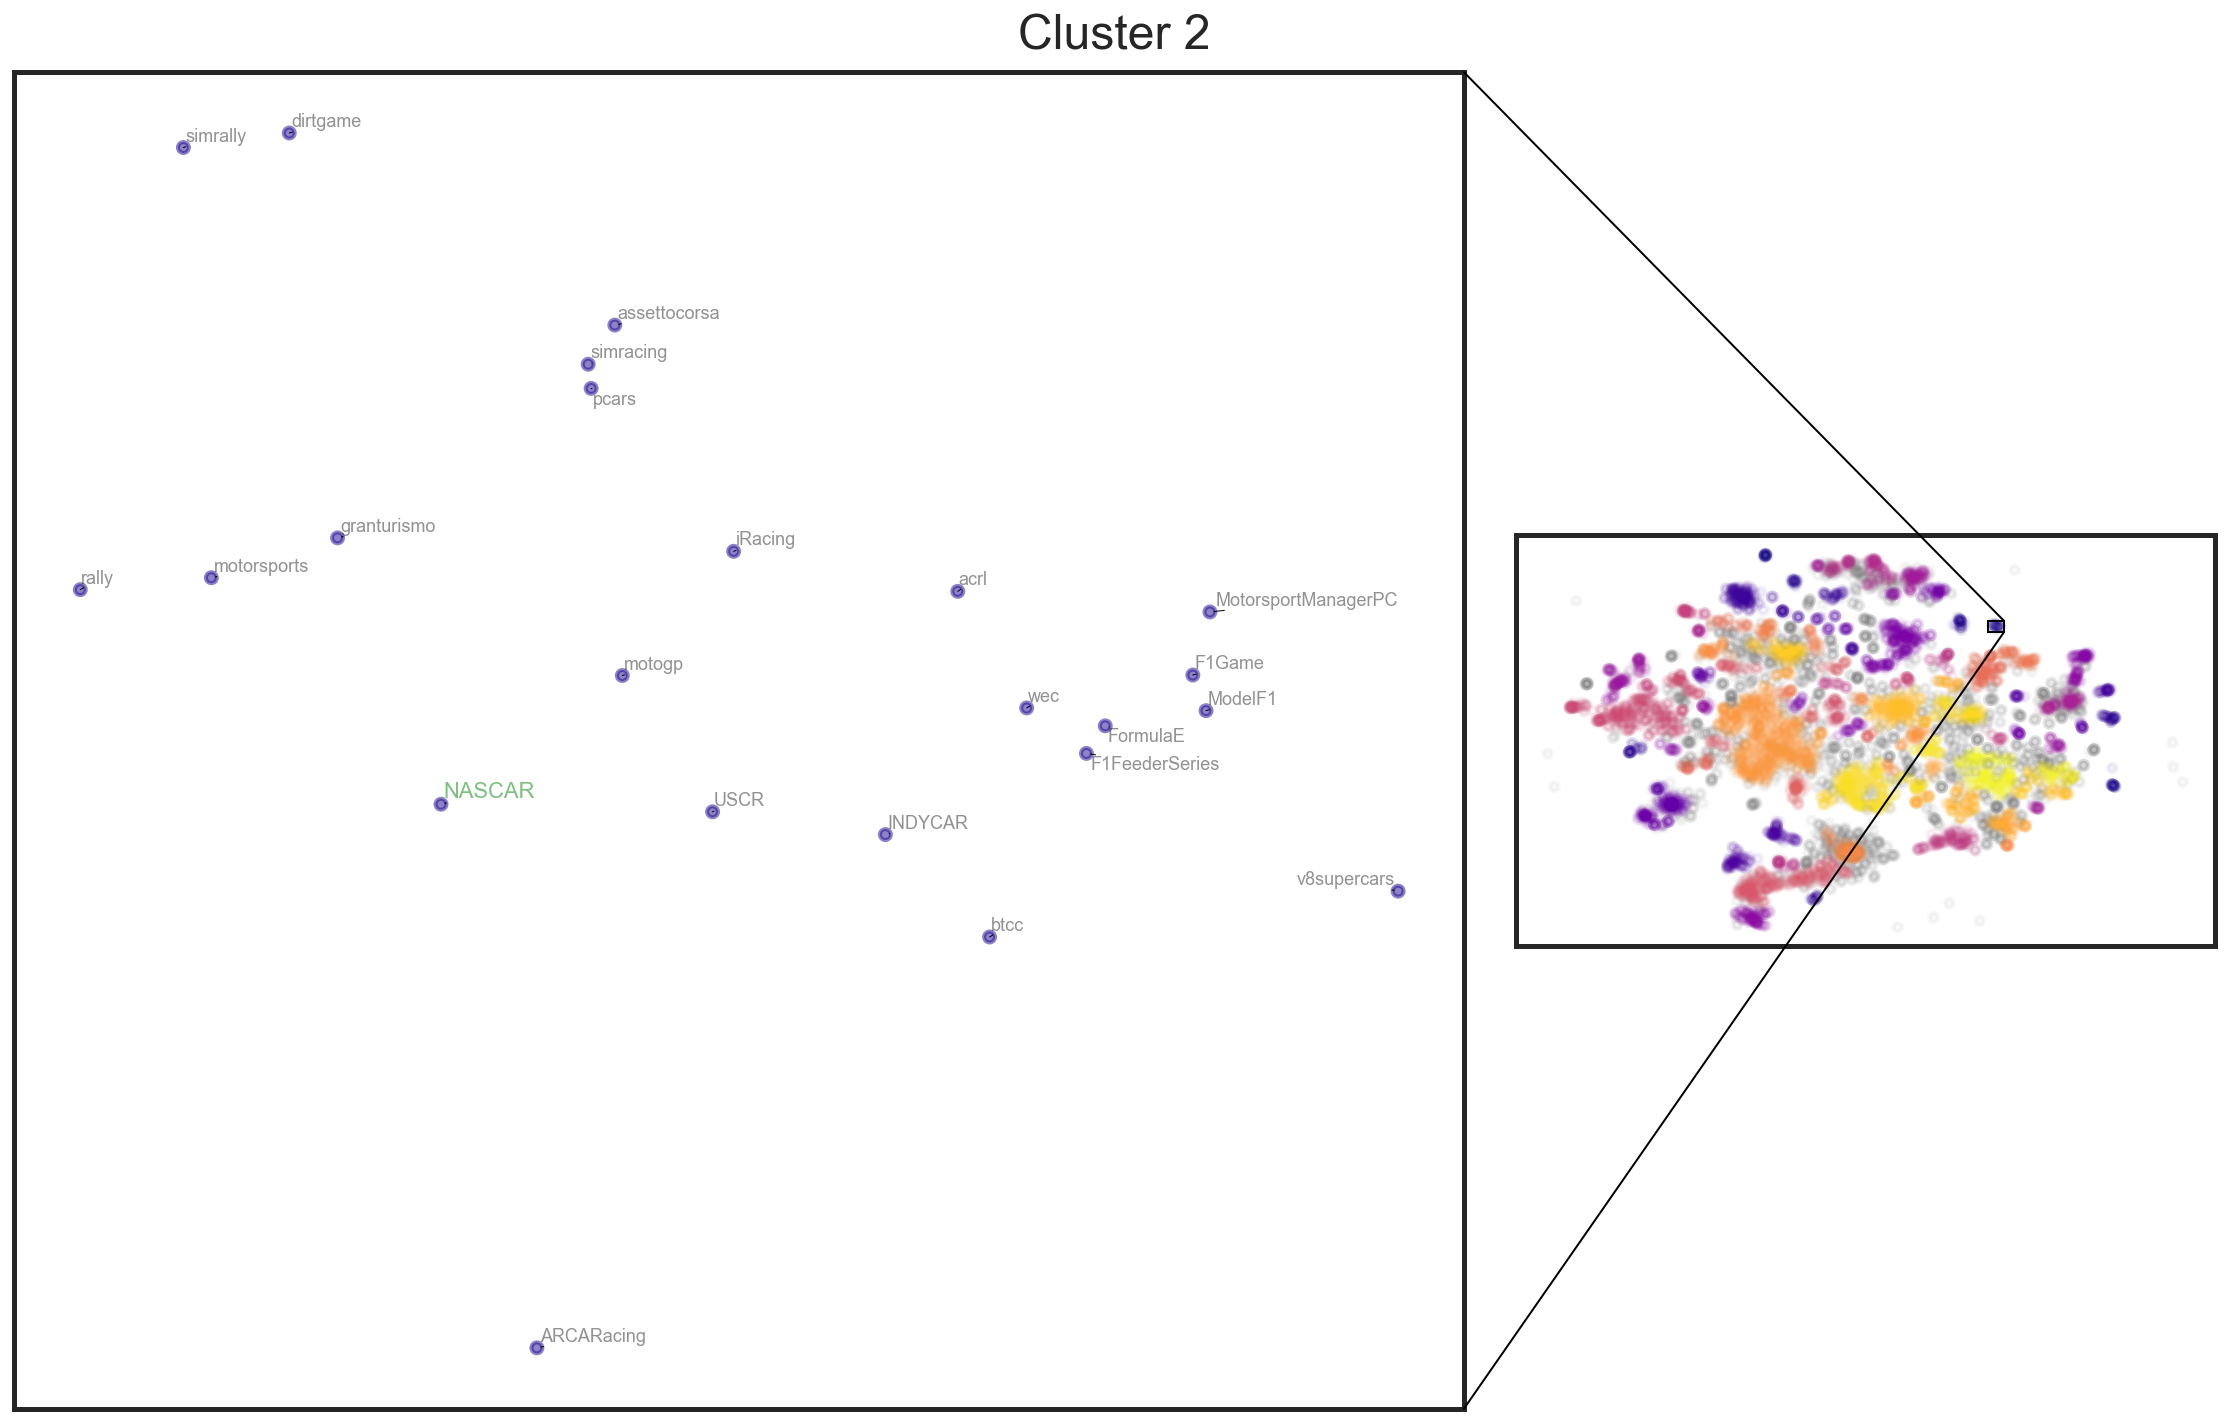

In [39]:
plot_cluster_by_id(subreddit_map_df, 2)

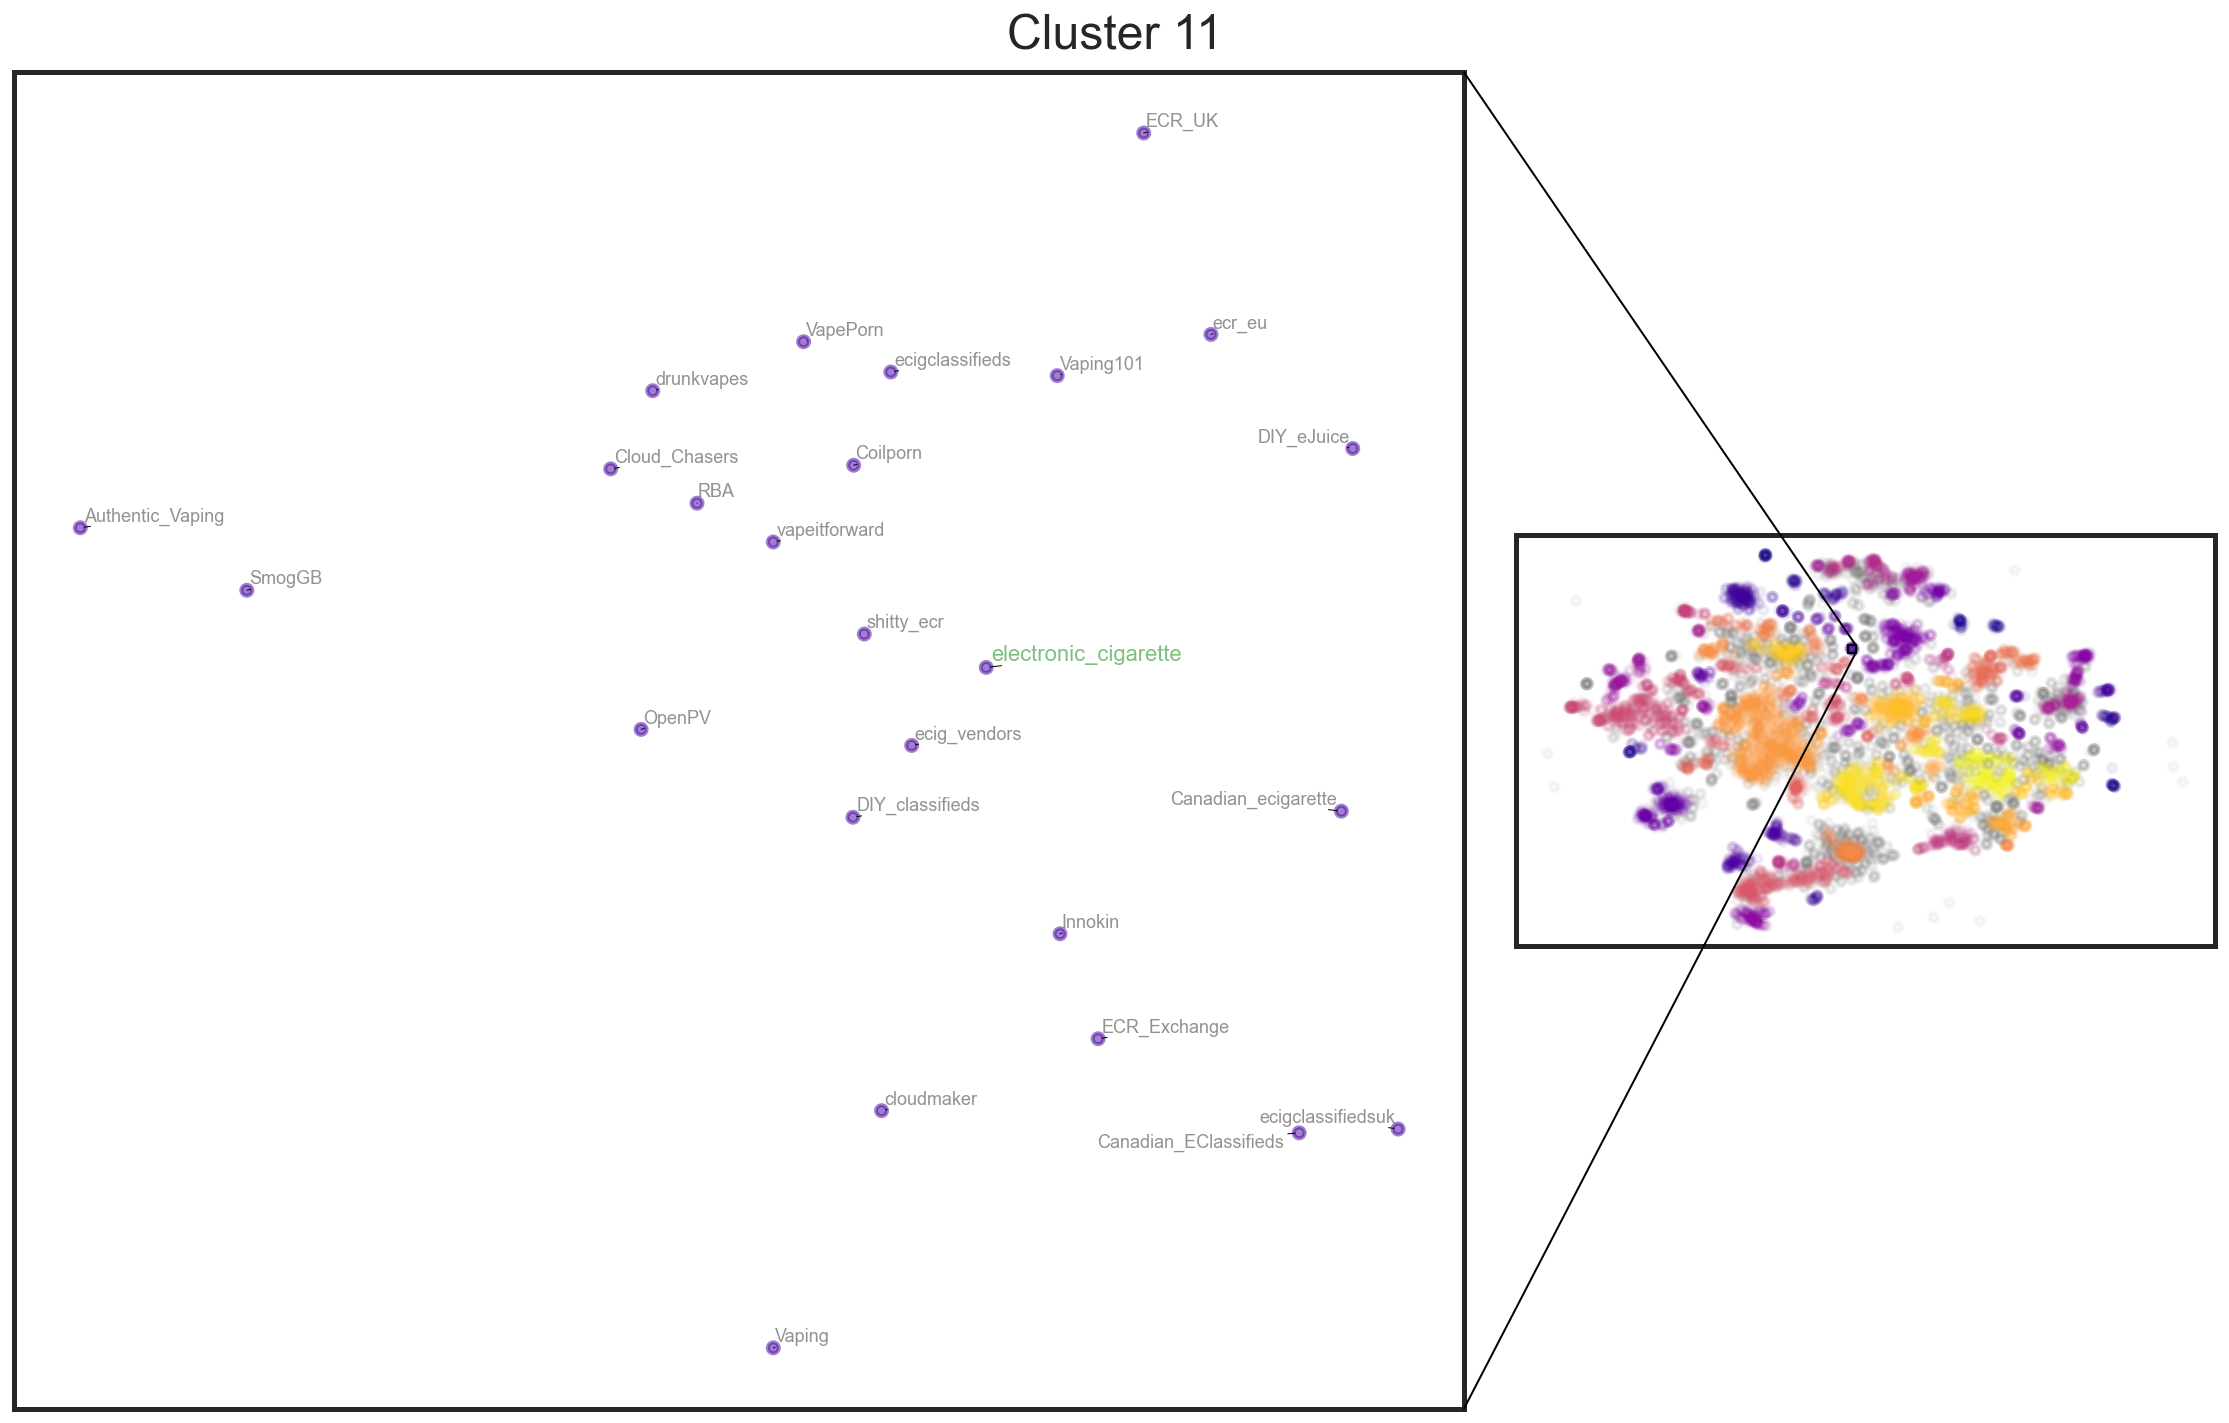

In [40]:
plot_cluster_by_id(subreddit_map_df, 11)

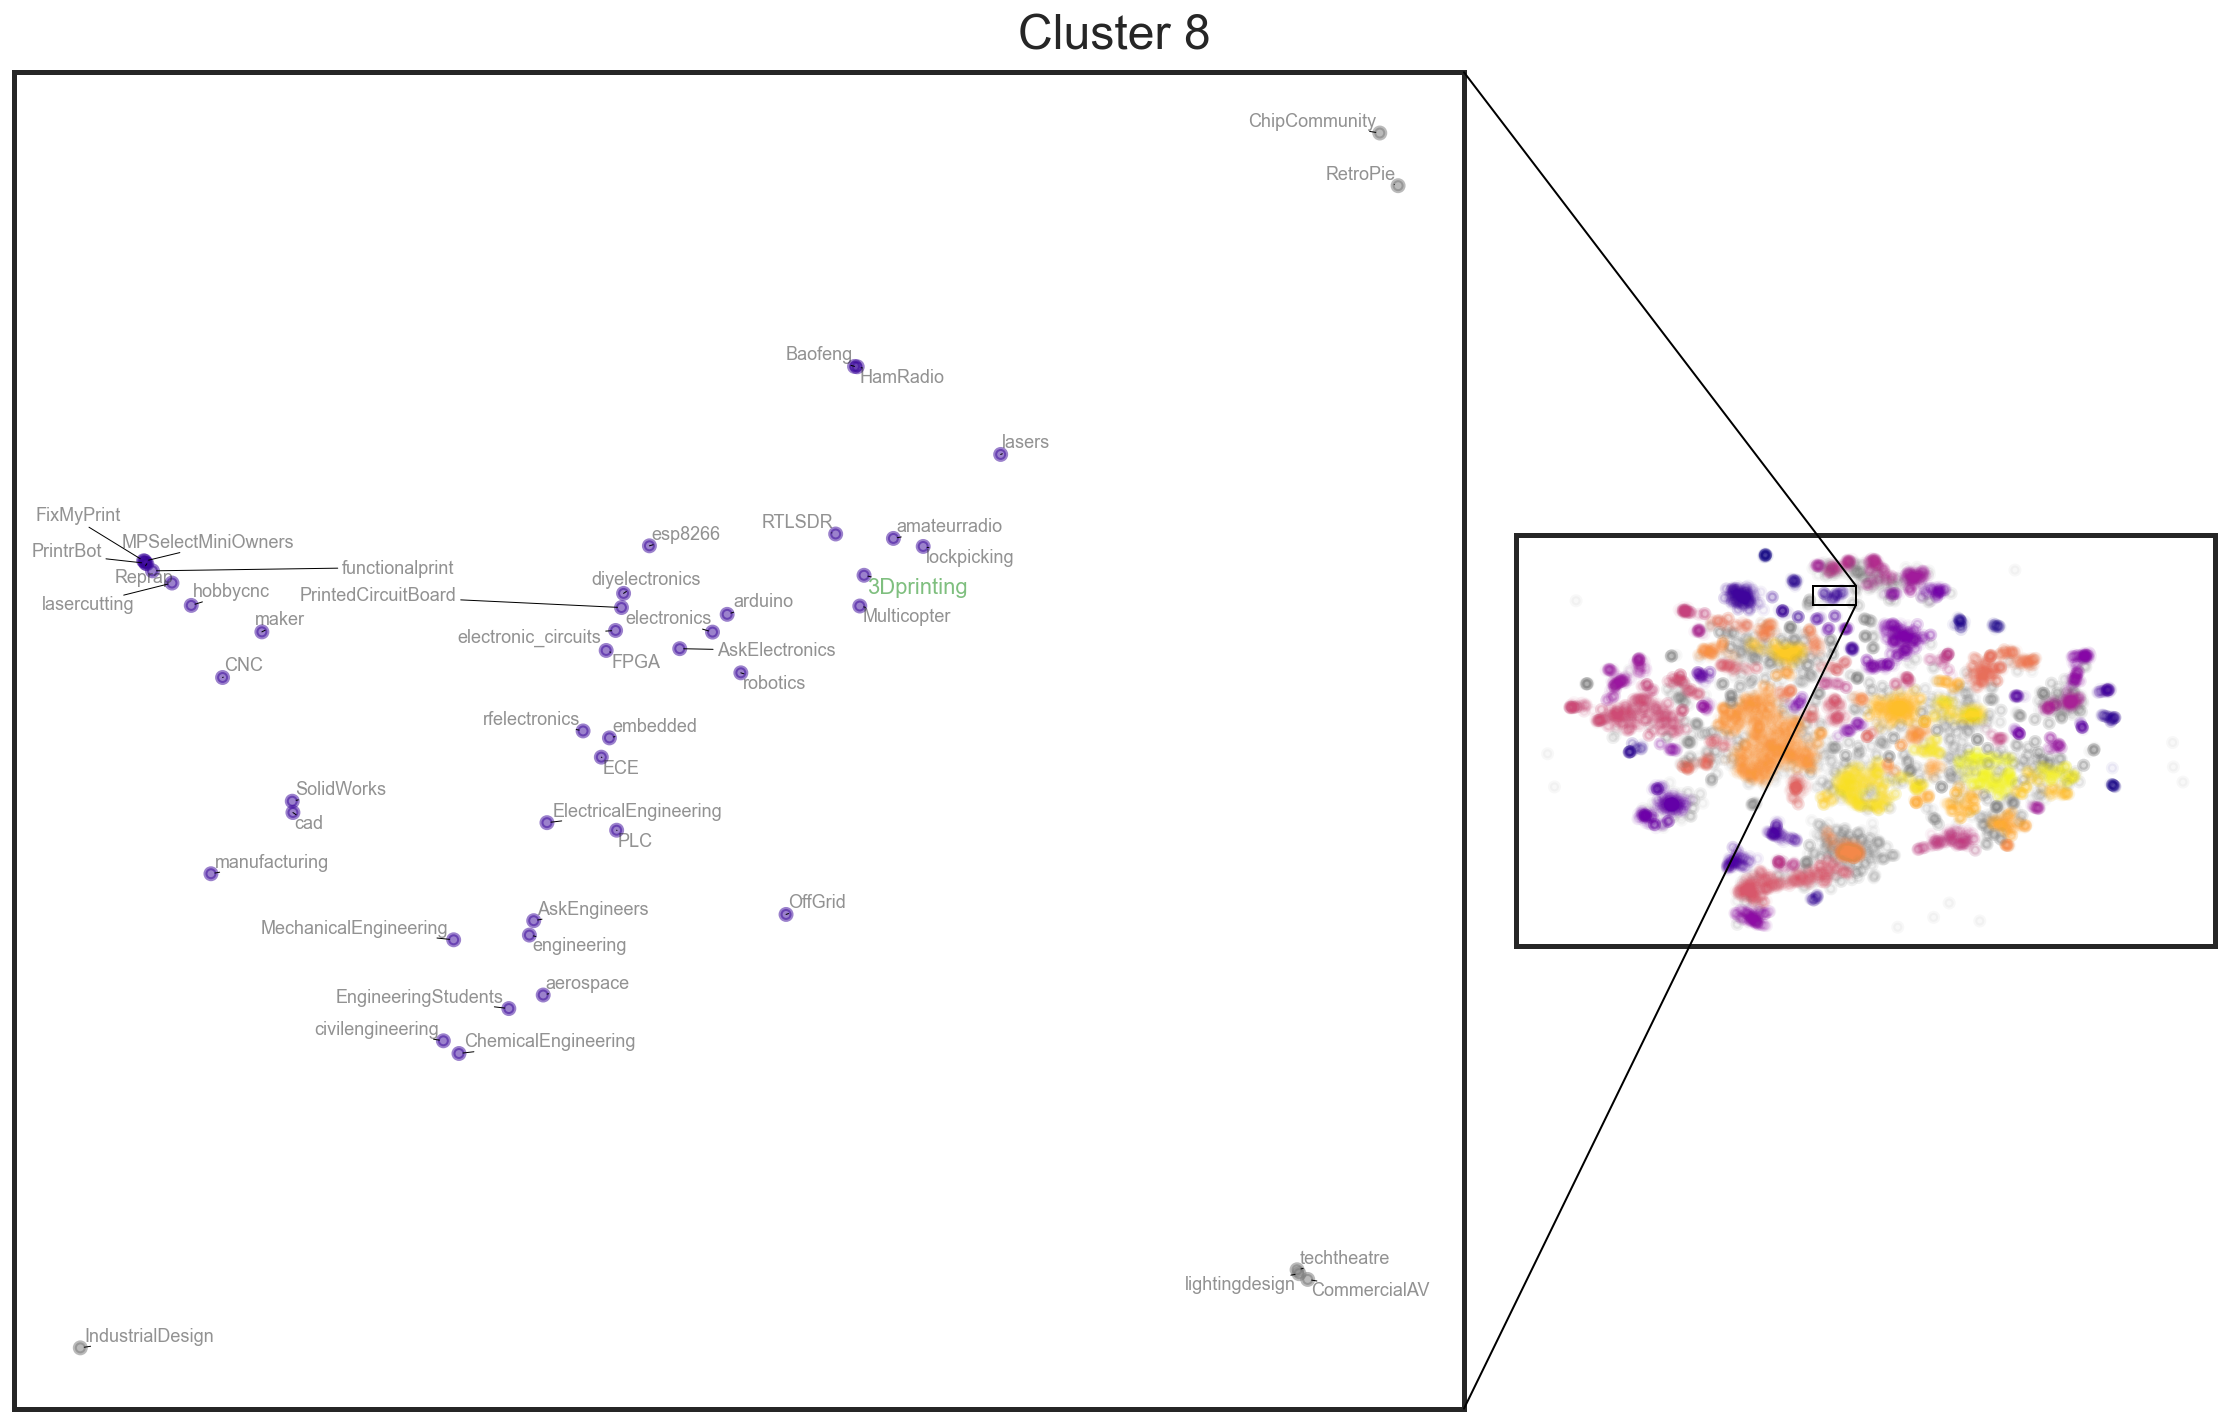

In [41]:
plot_cluster_by_id(subreddit_map_df, 8)

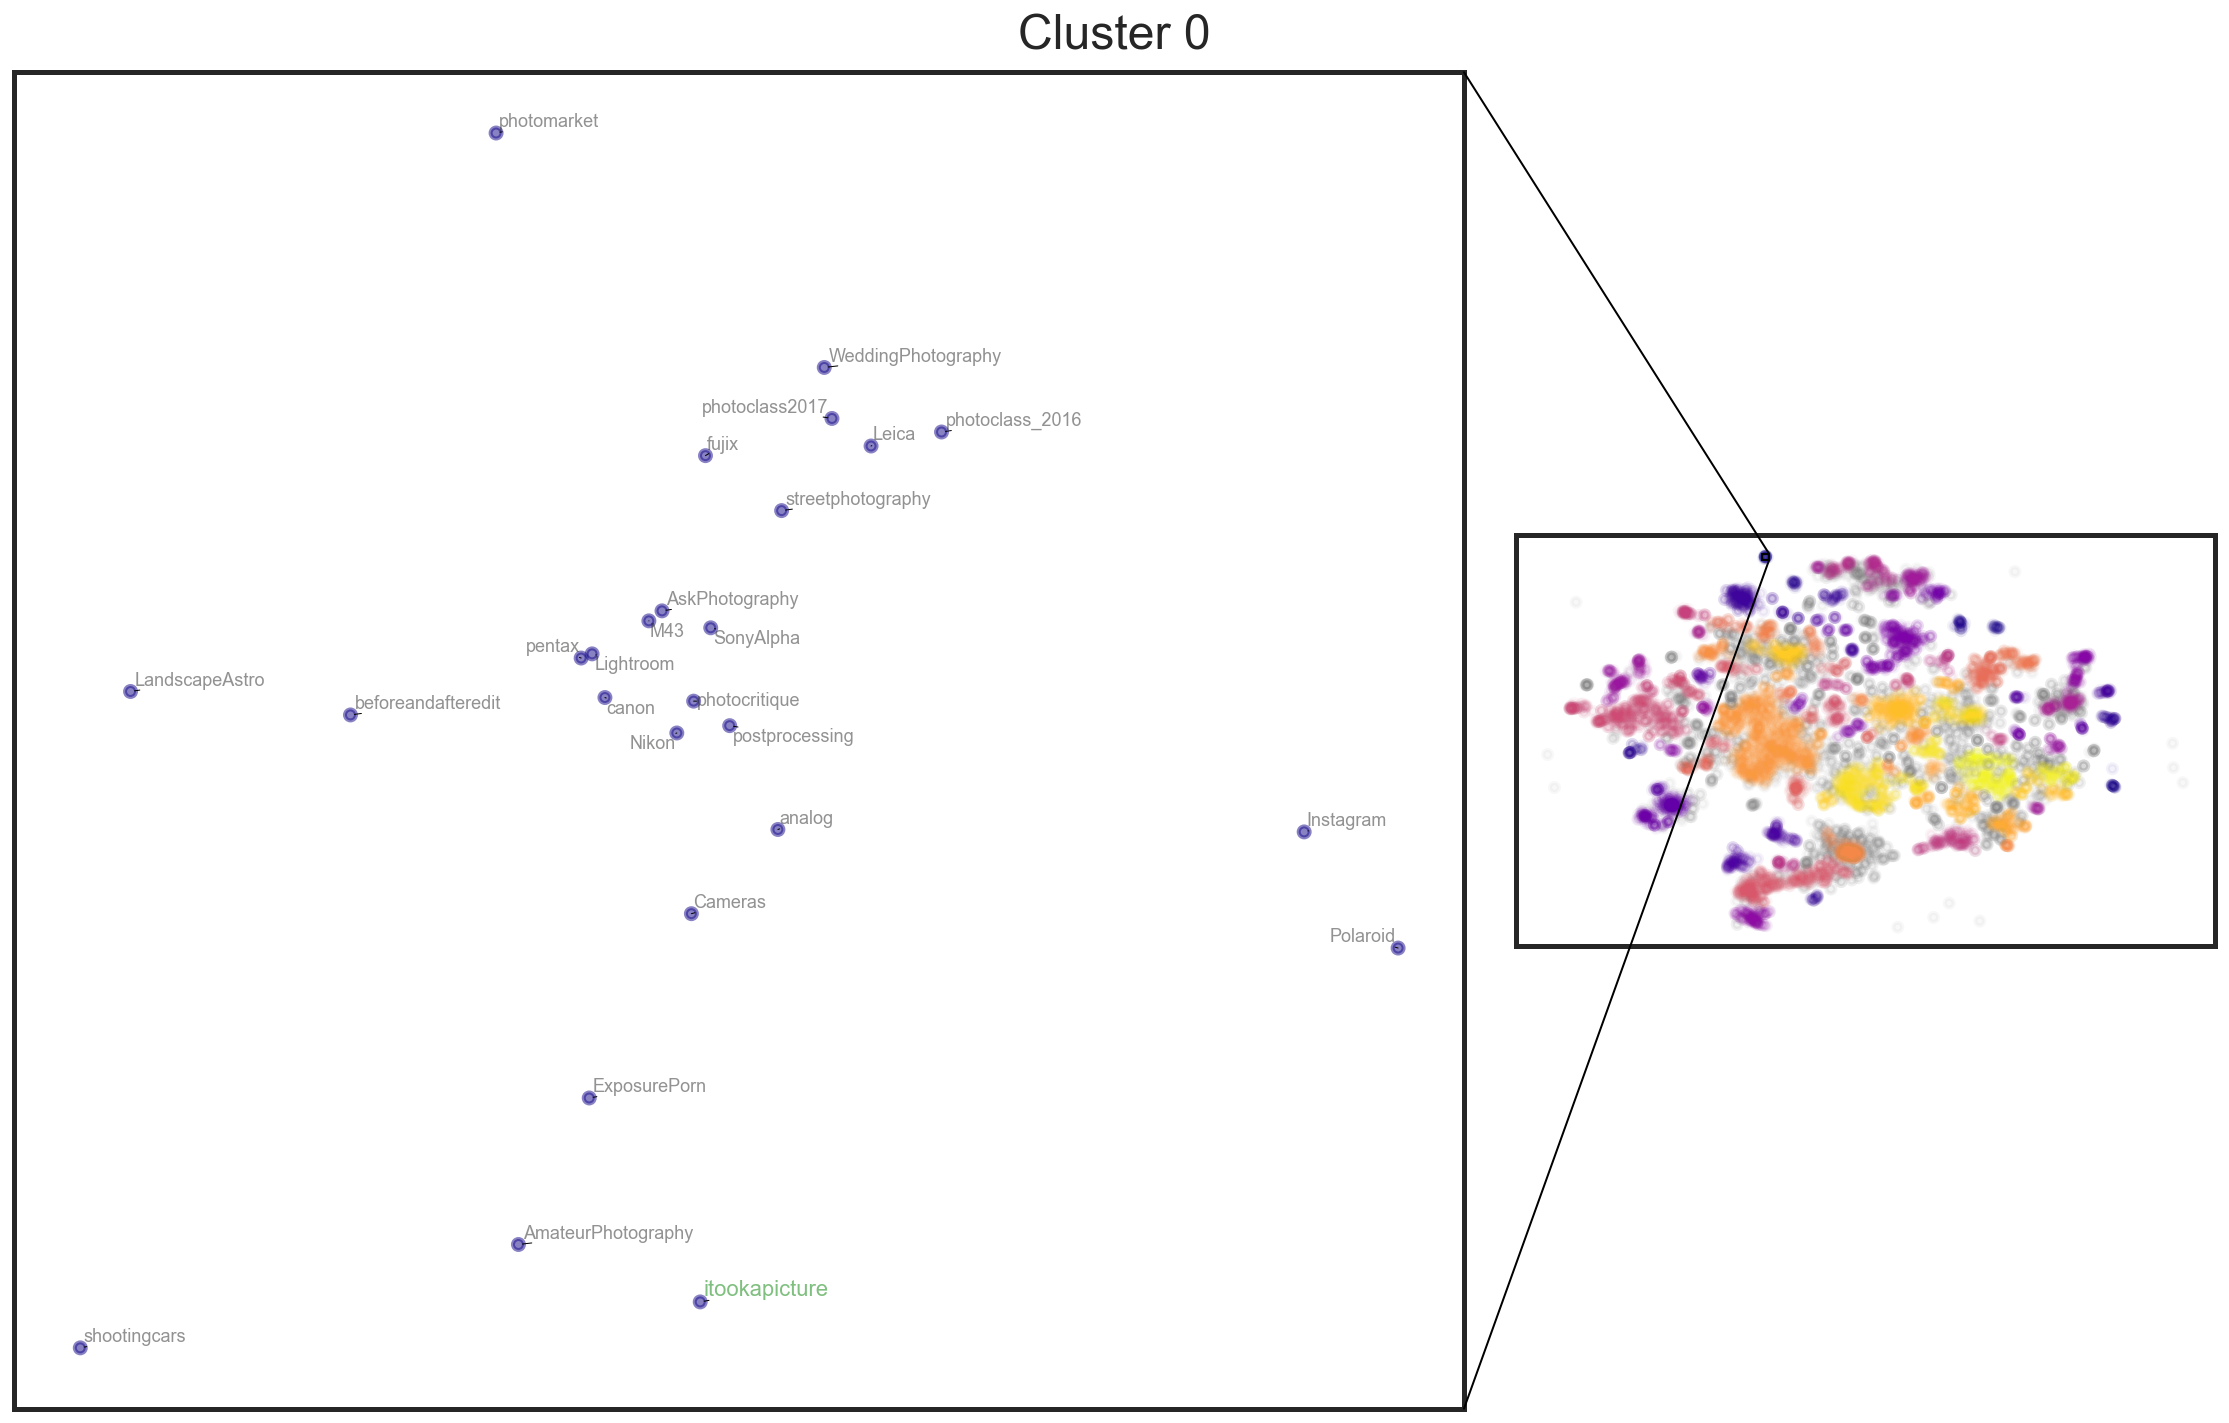

In [42]:
plot_cluster_by_id(subreddit_map_df, 0)

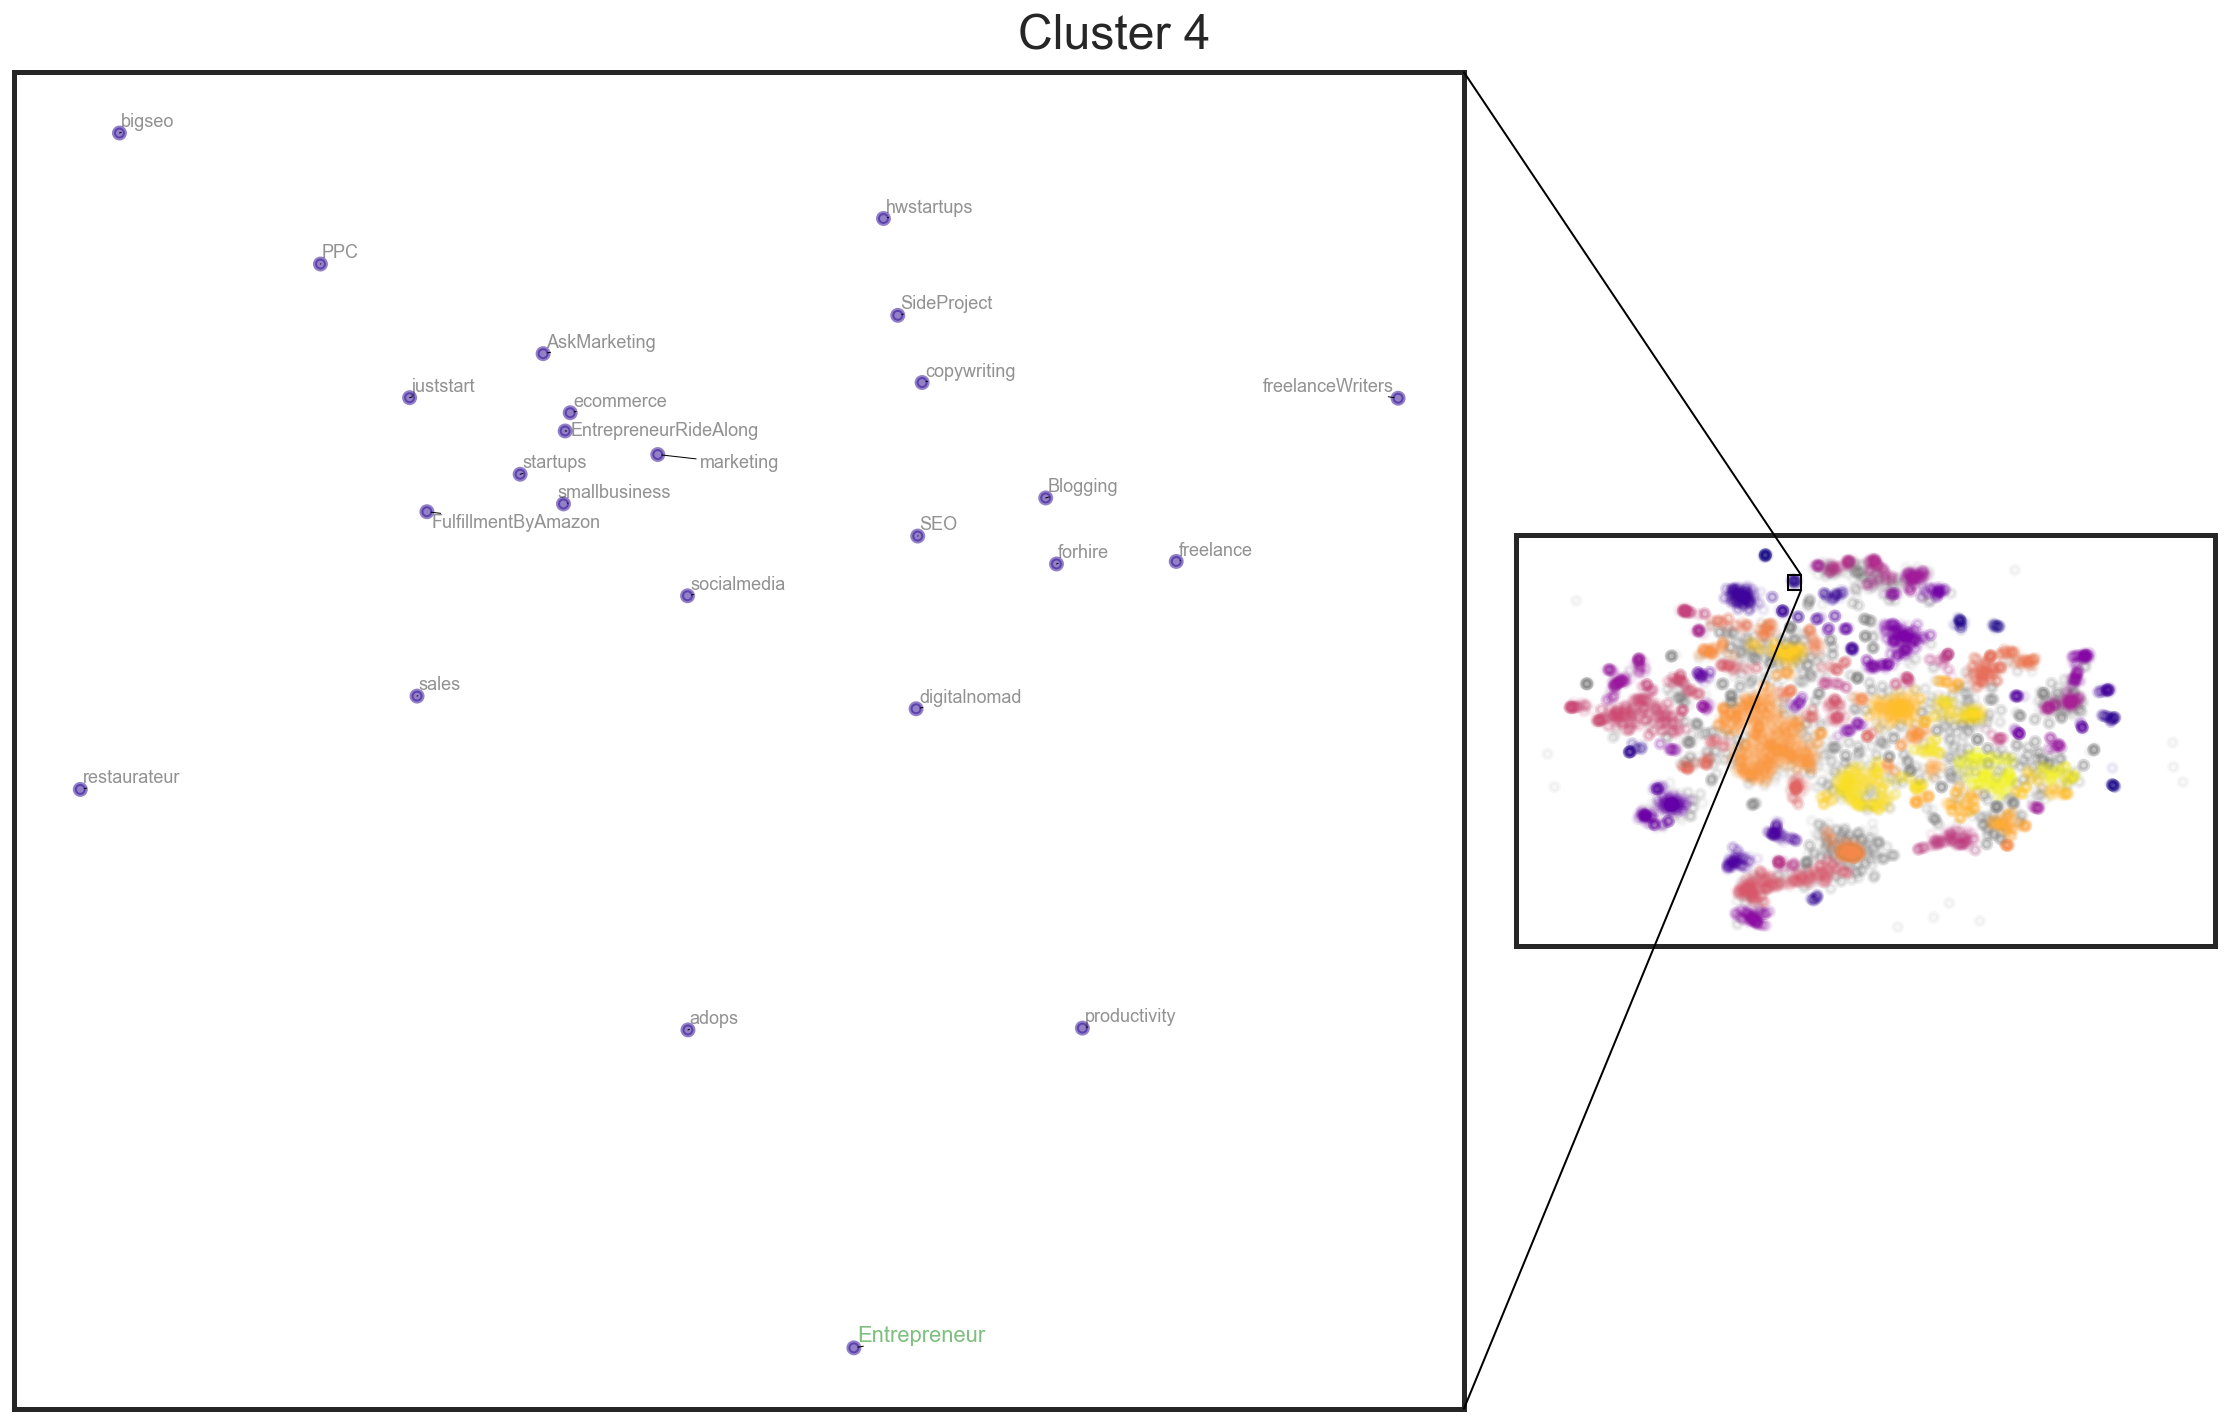

In [43]:
plot_cluster_by_id(subreddit_map_df, 4)

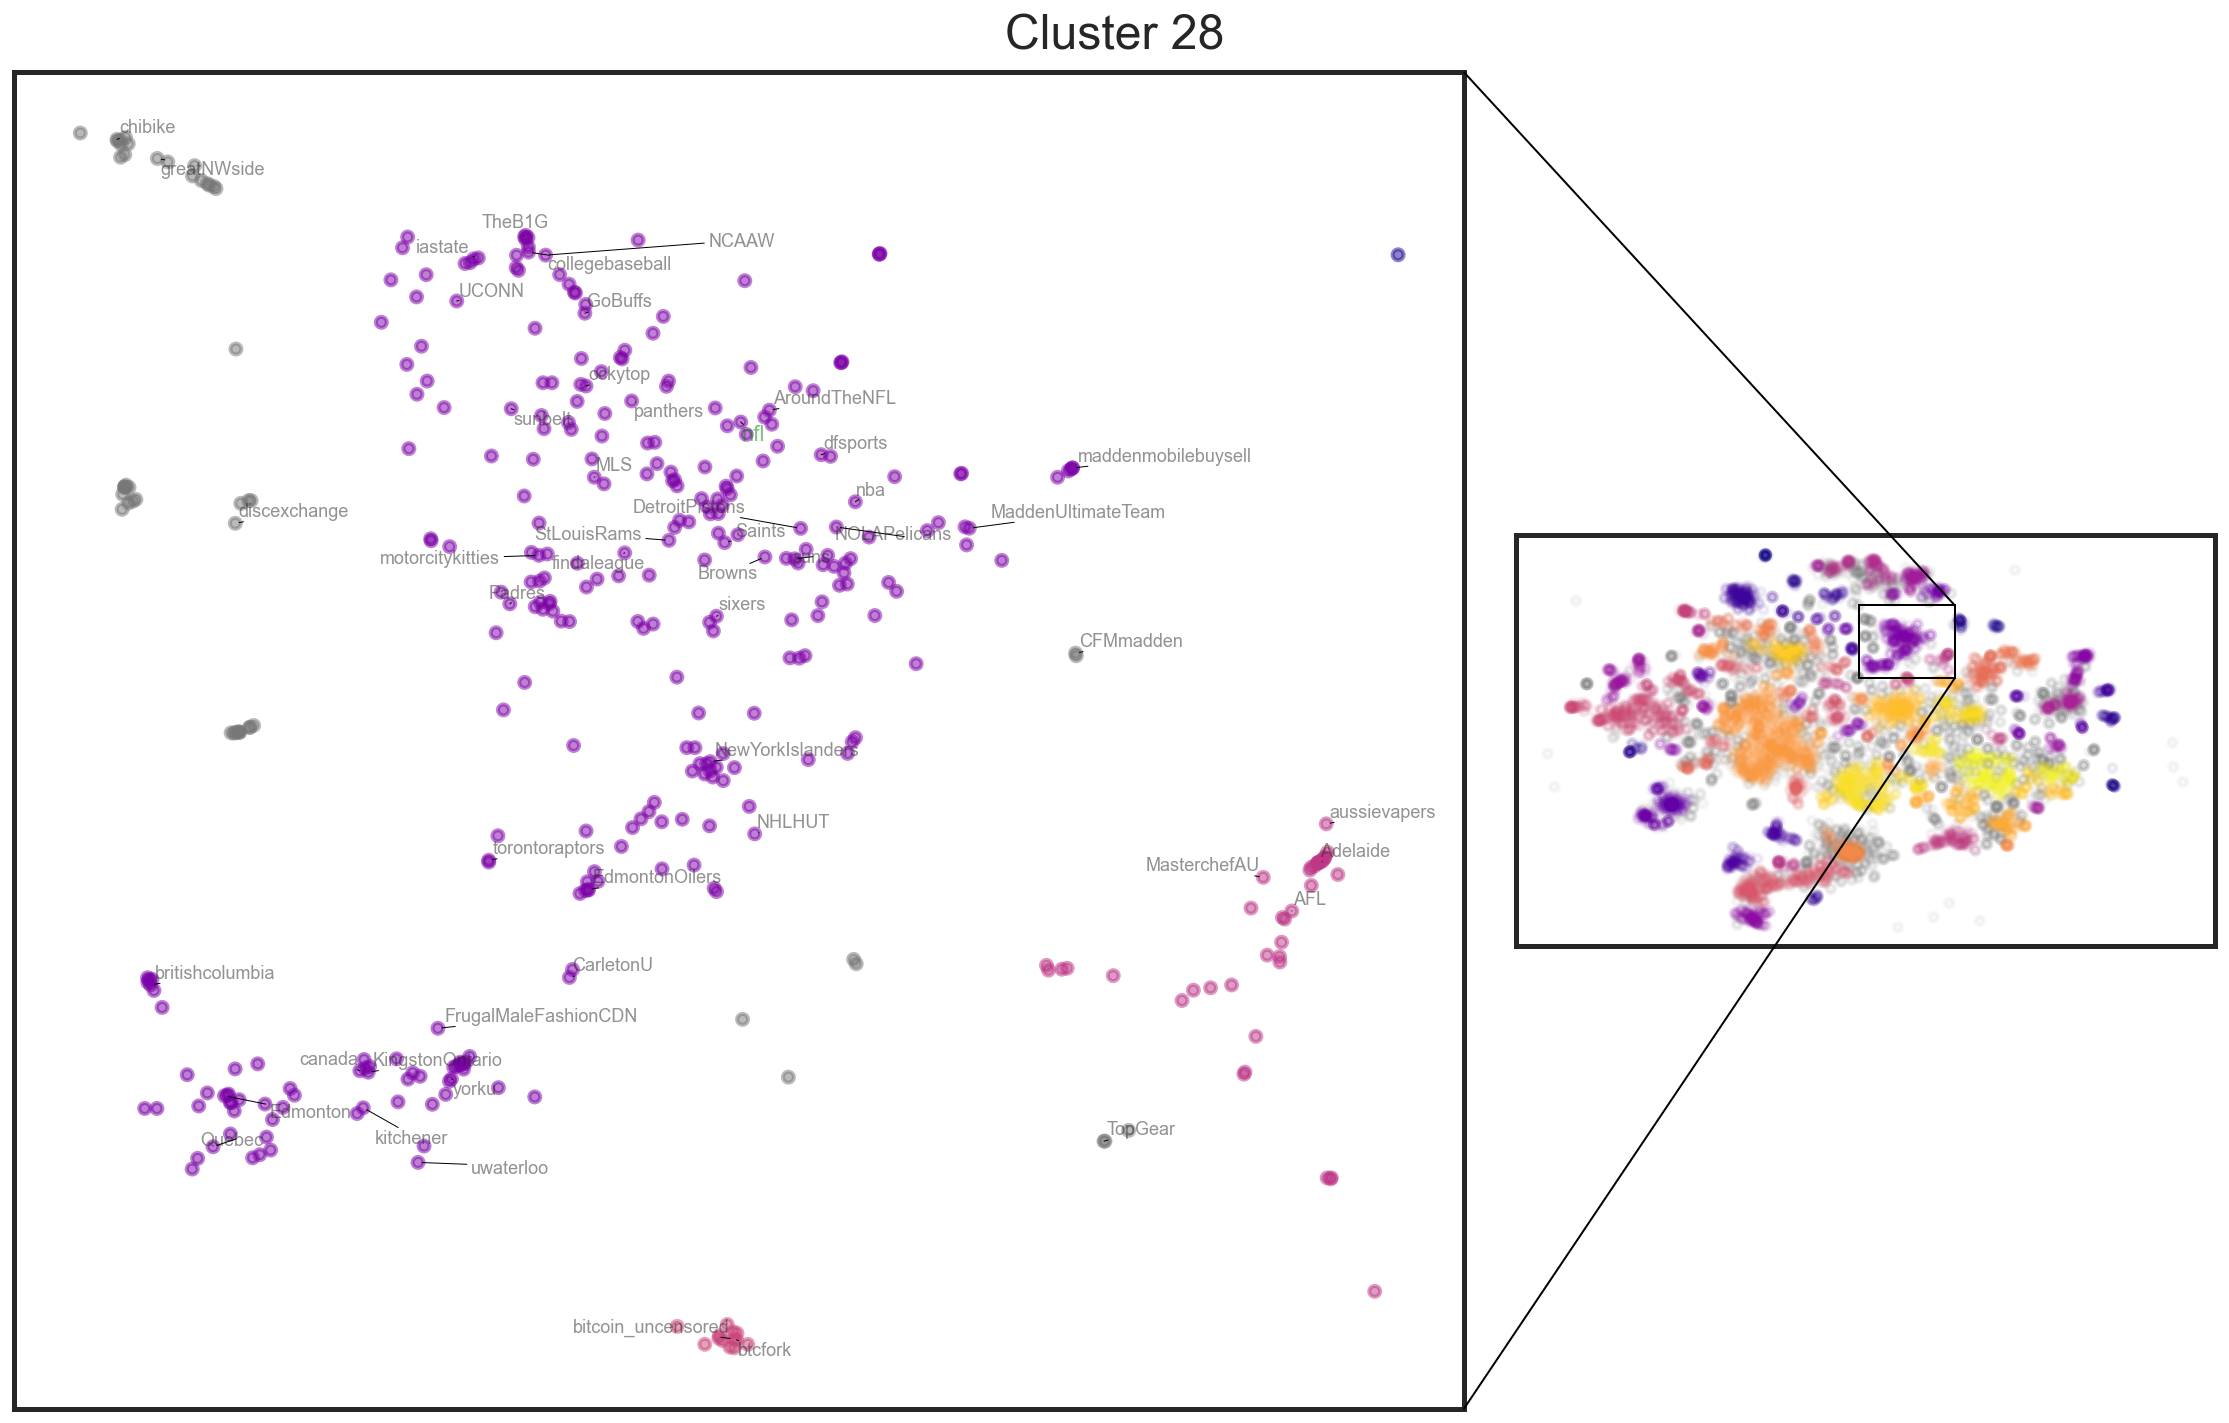

In [44]:
plot_cluster_by_id(subreddit_map_df, 28)

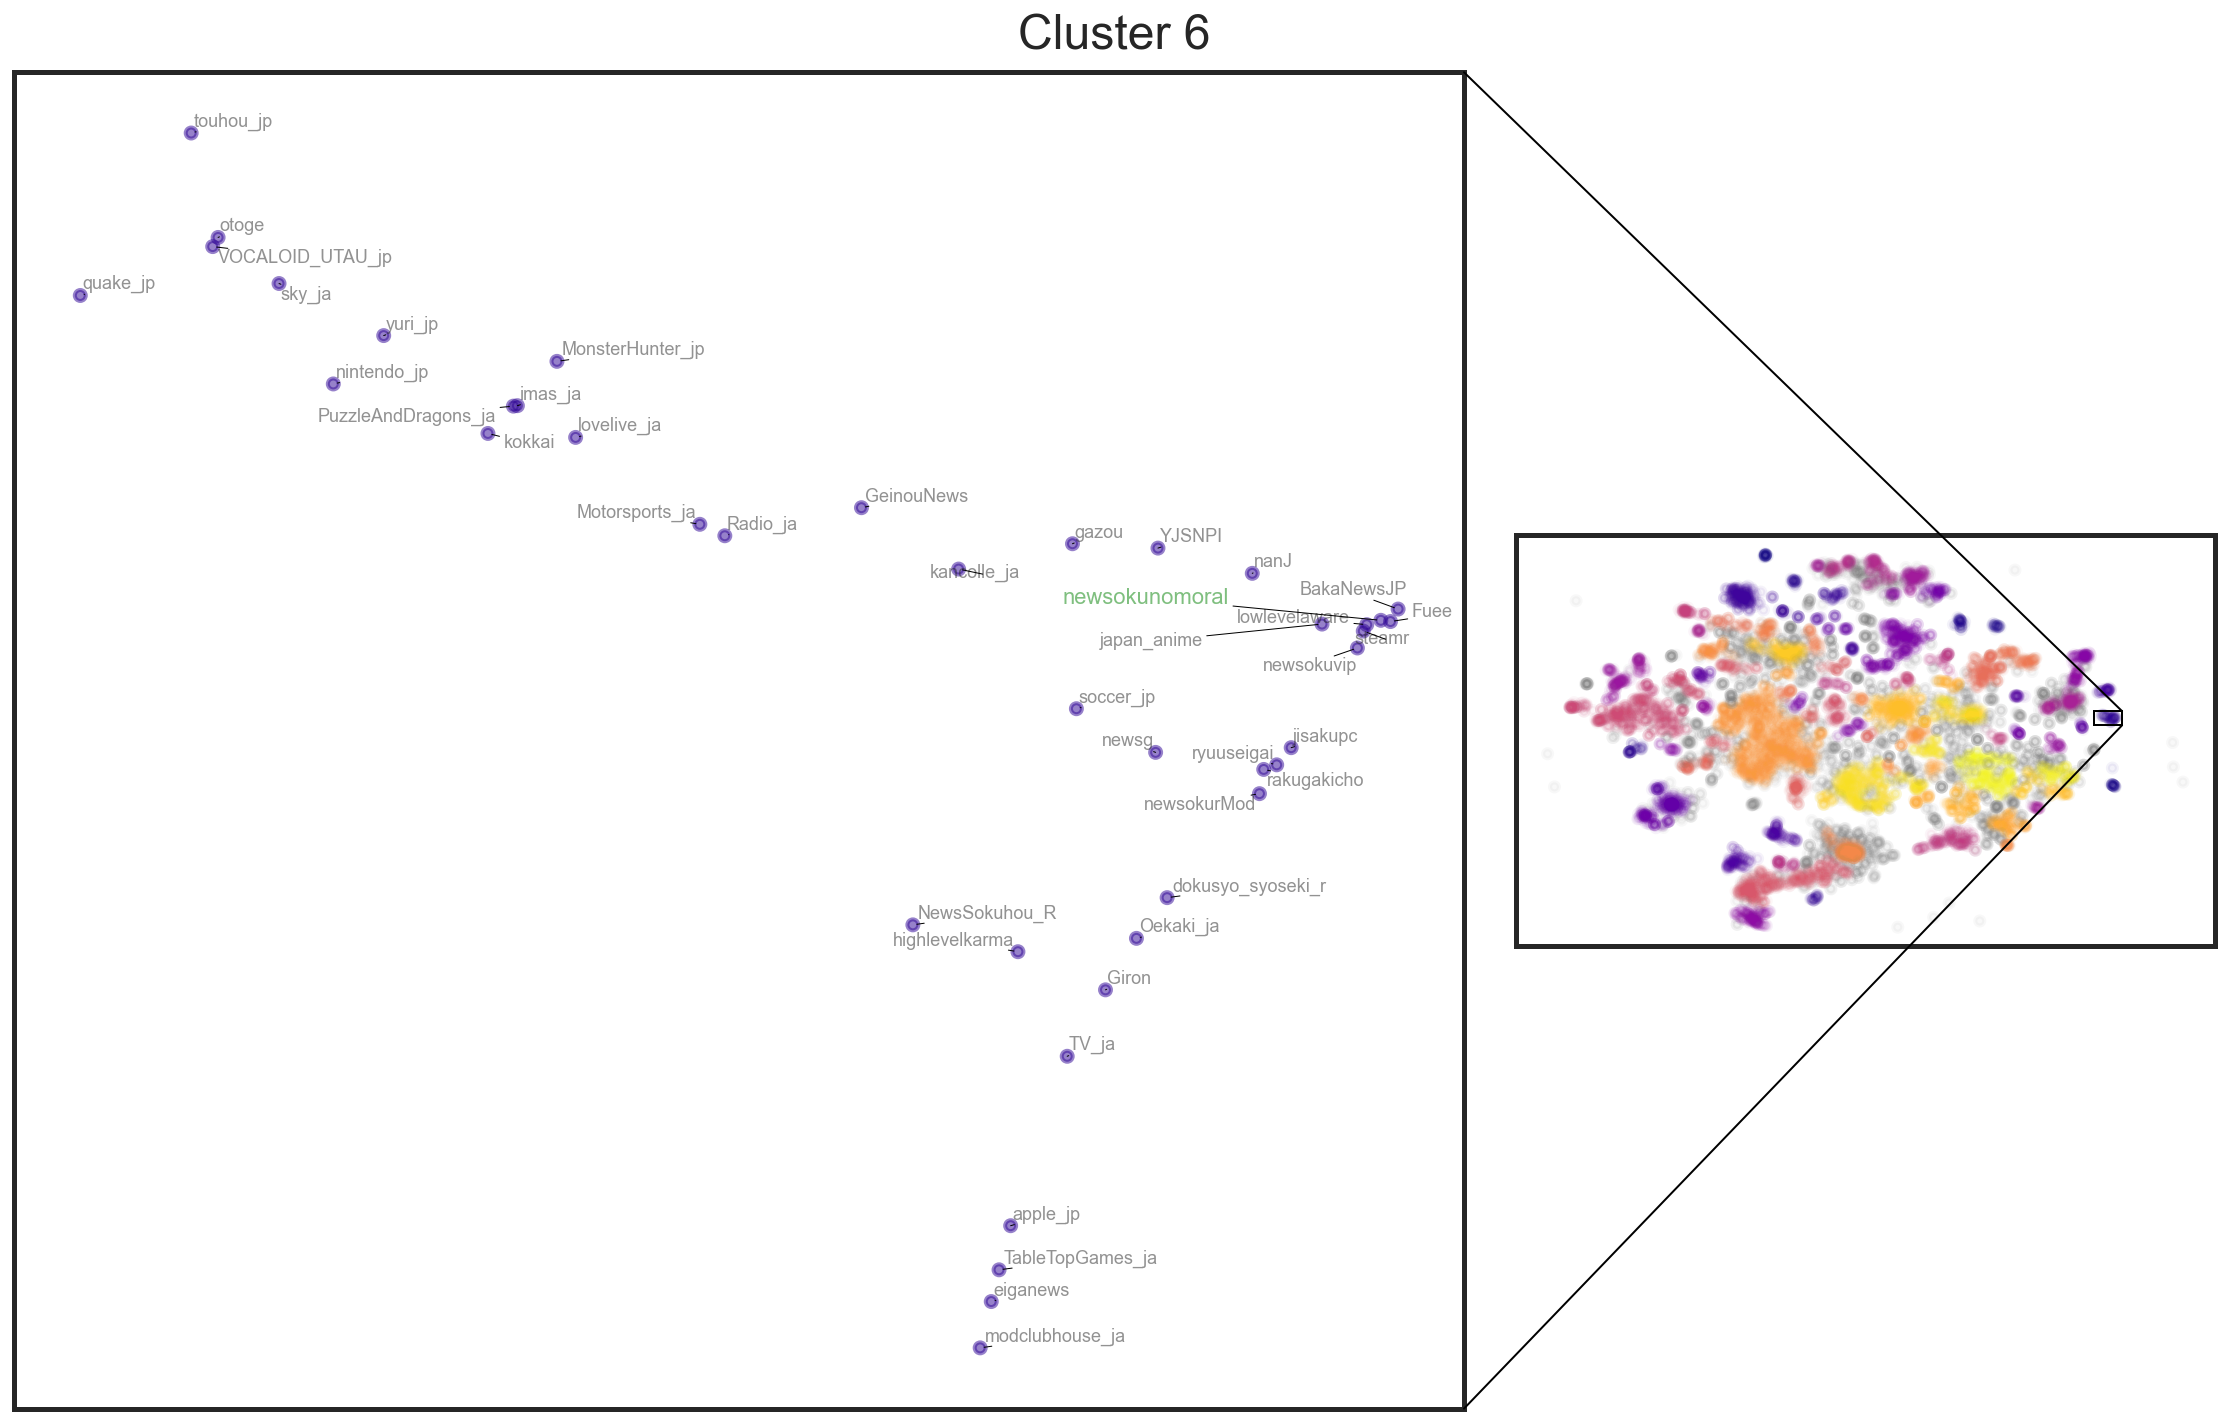

In [45]:
plot_cluster_by_id(subreddit_map_df, 6)

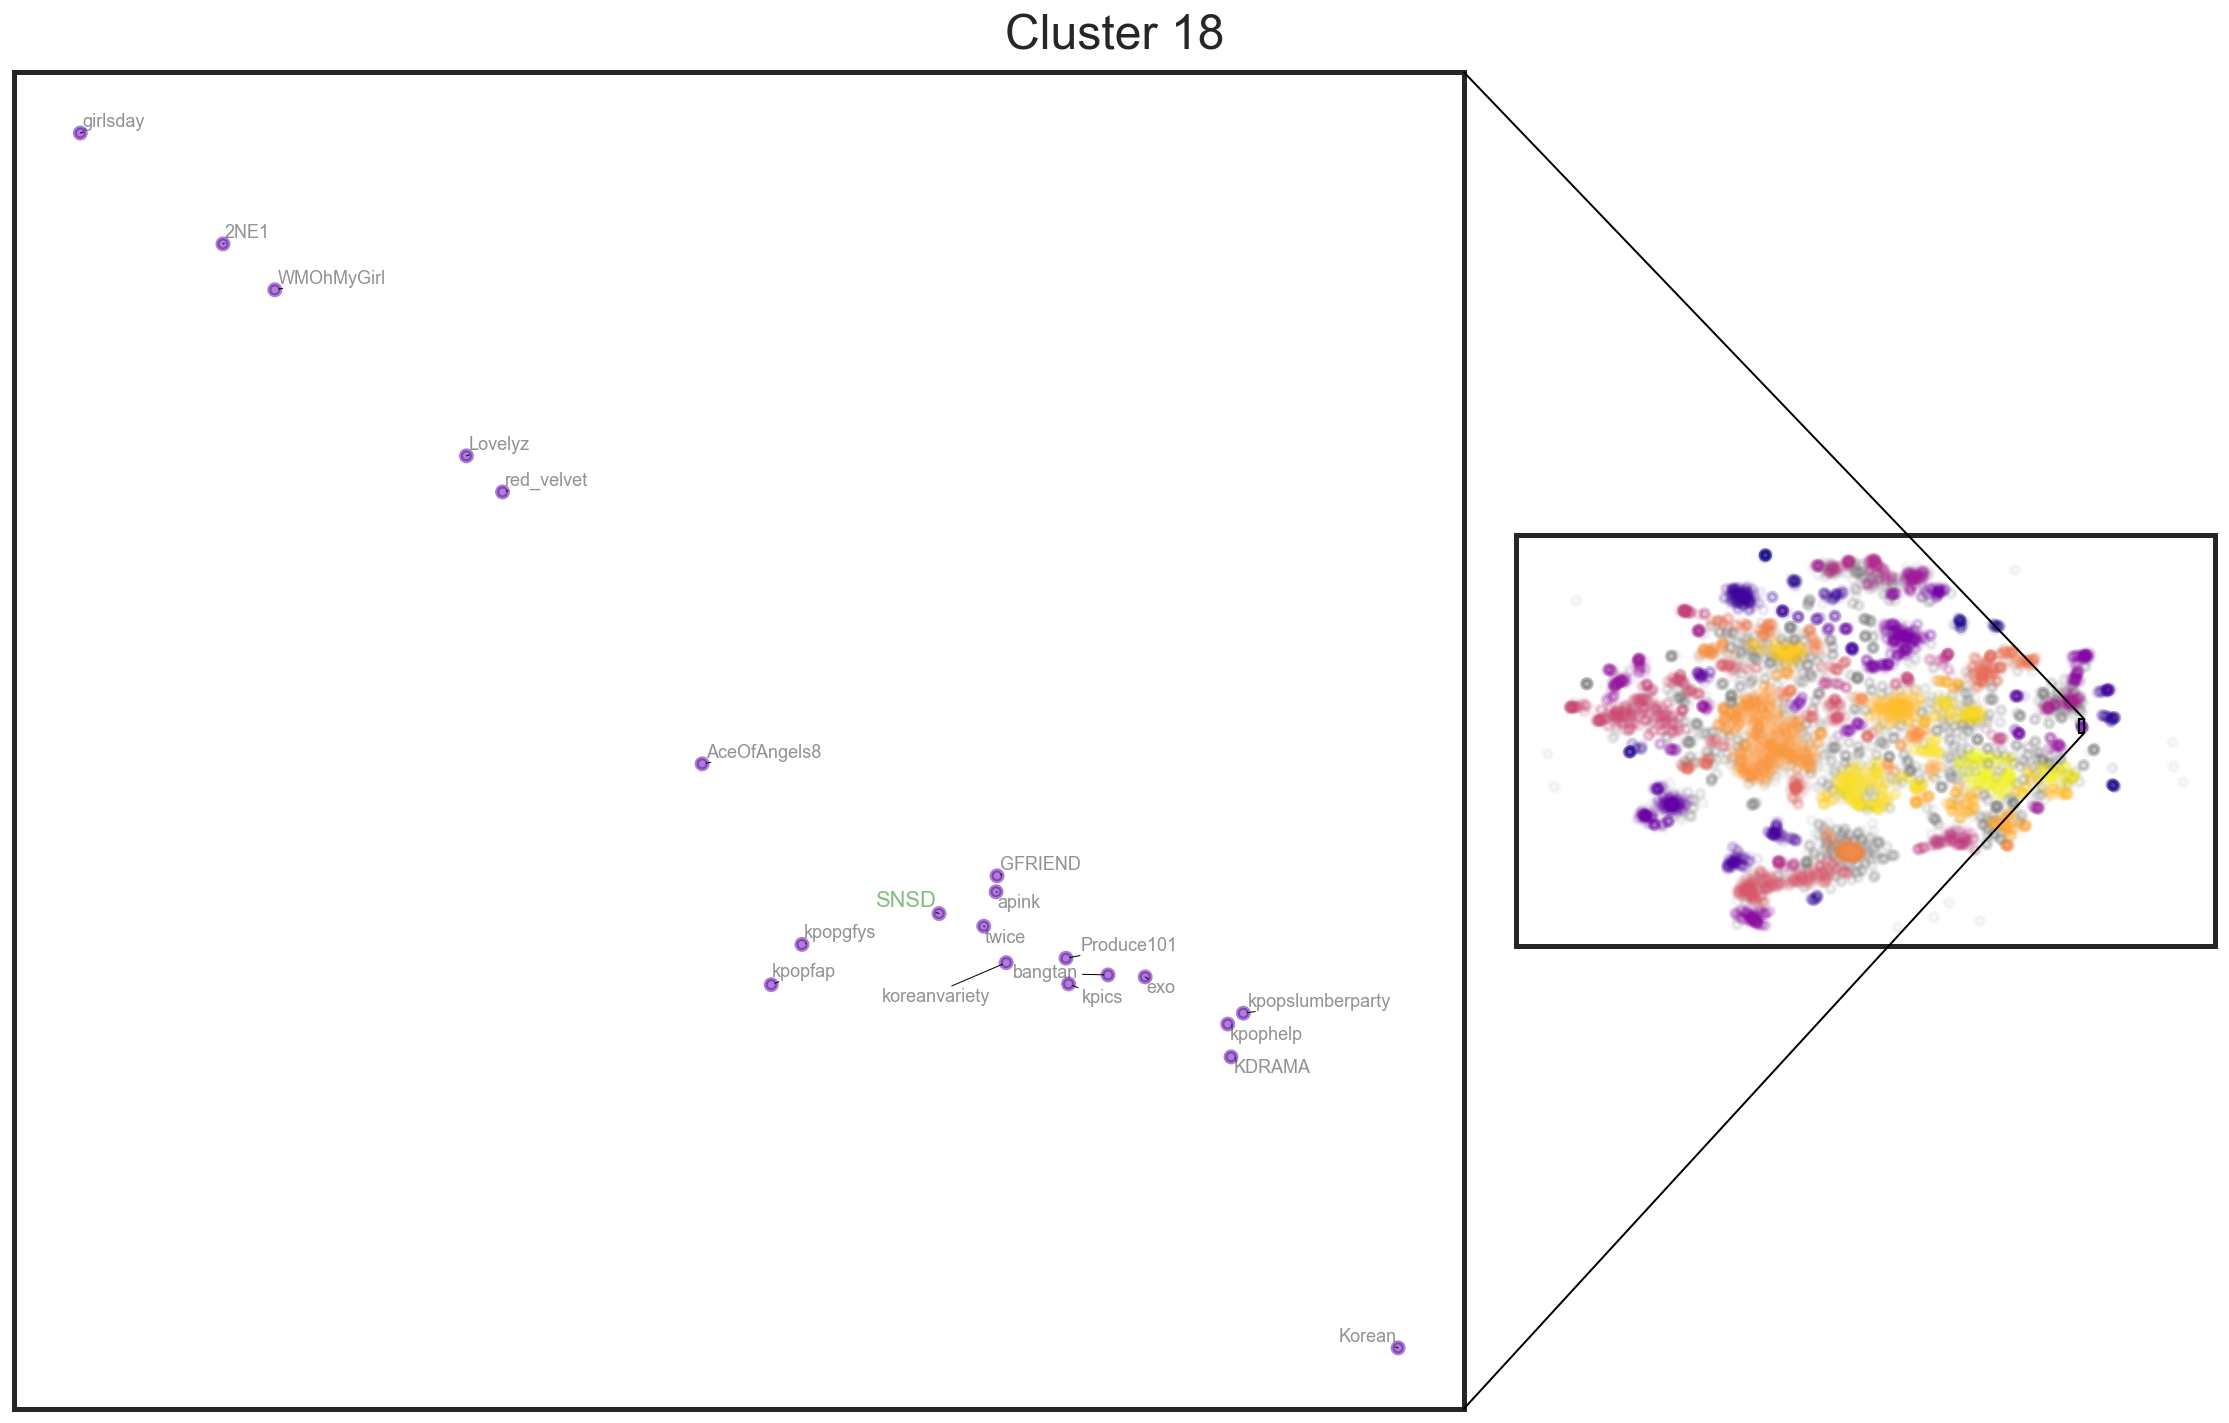

In [46]:
plot_cluster_by_id(subreddit_map_df, 18)

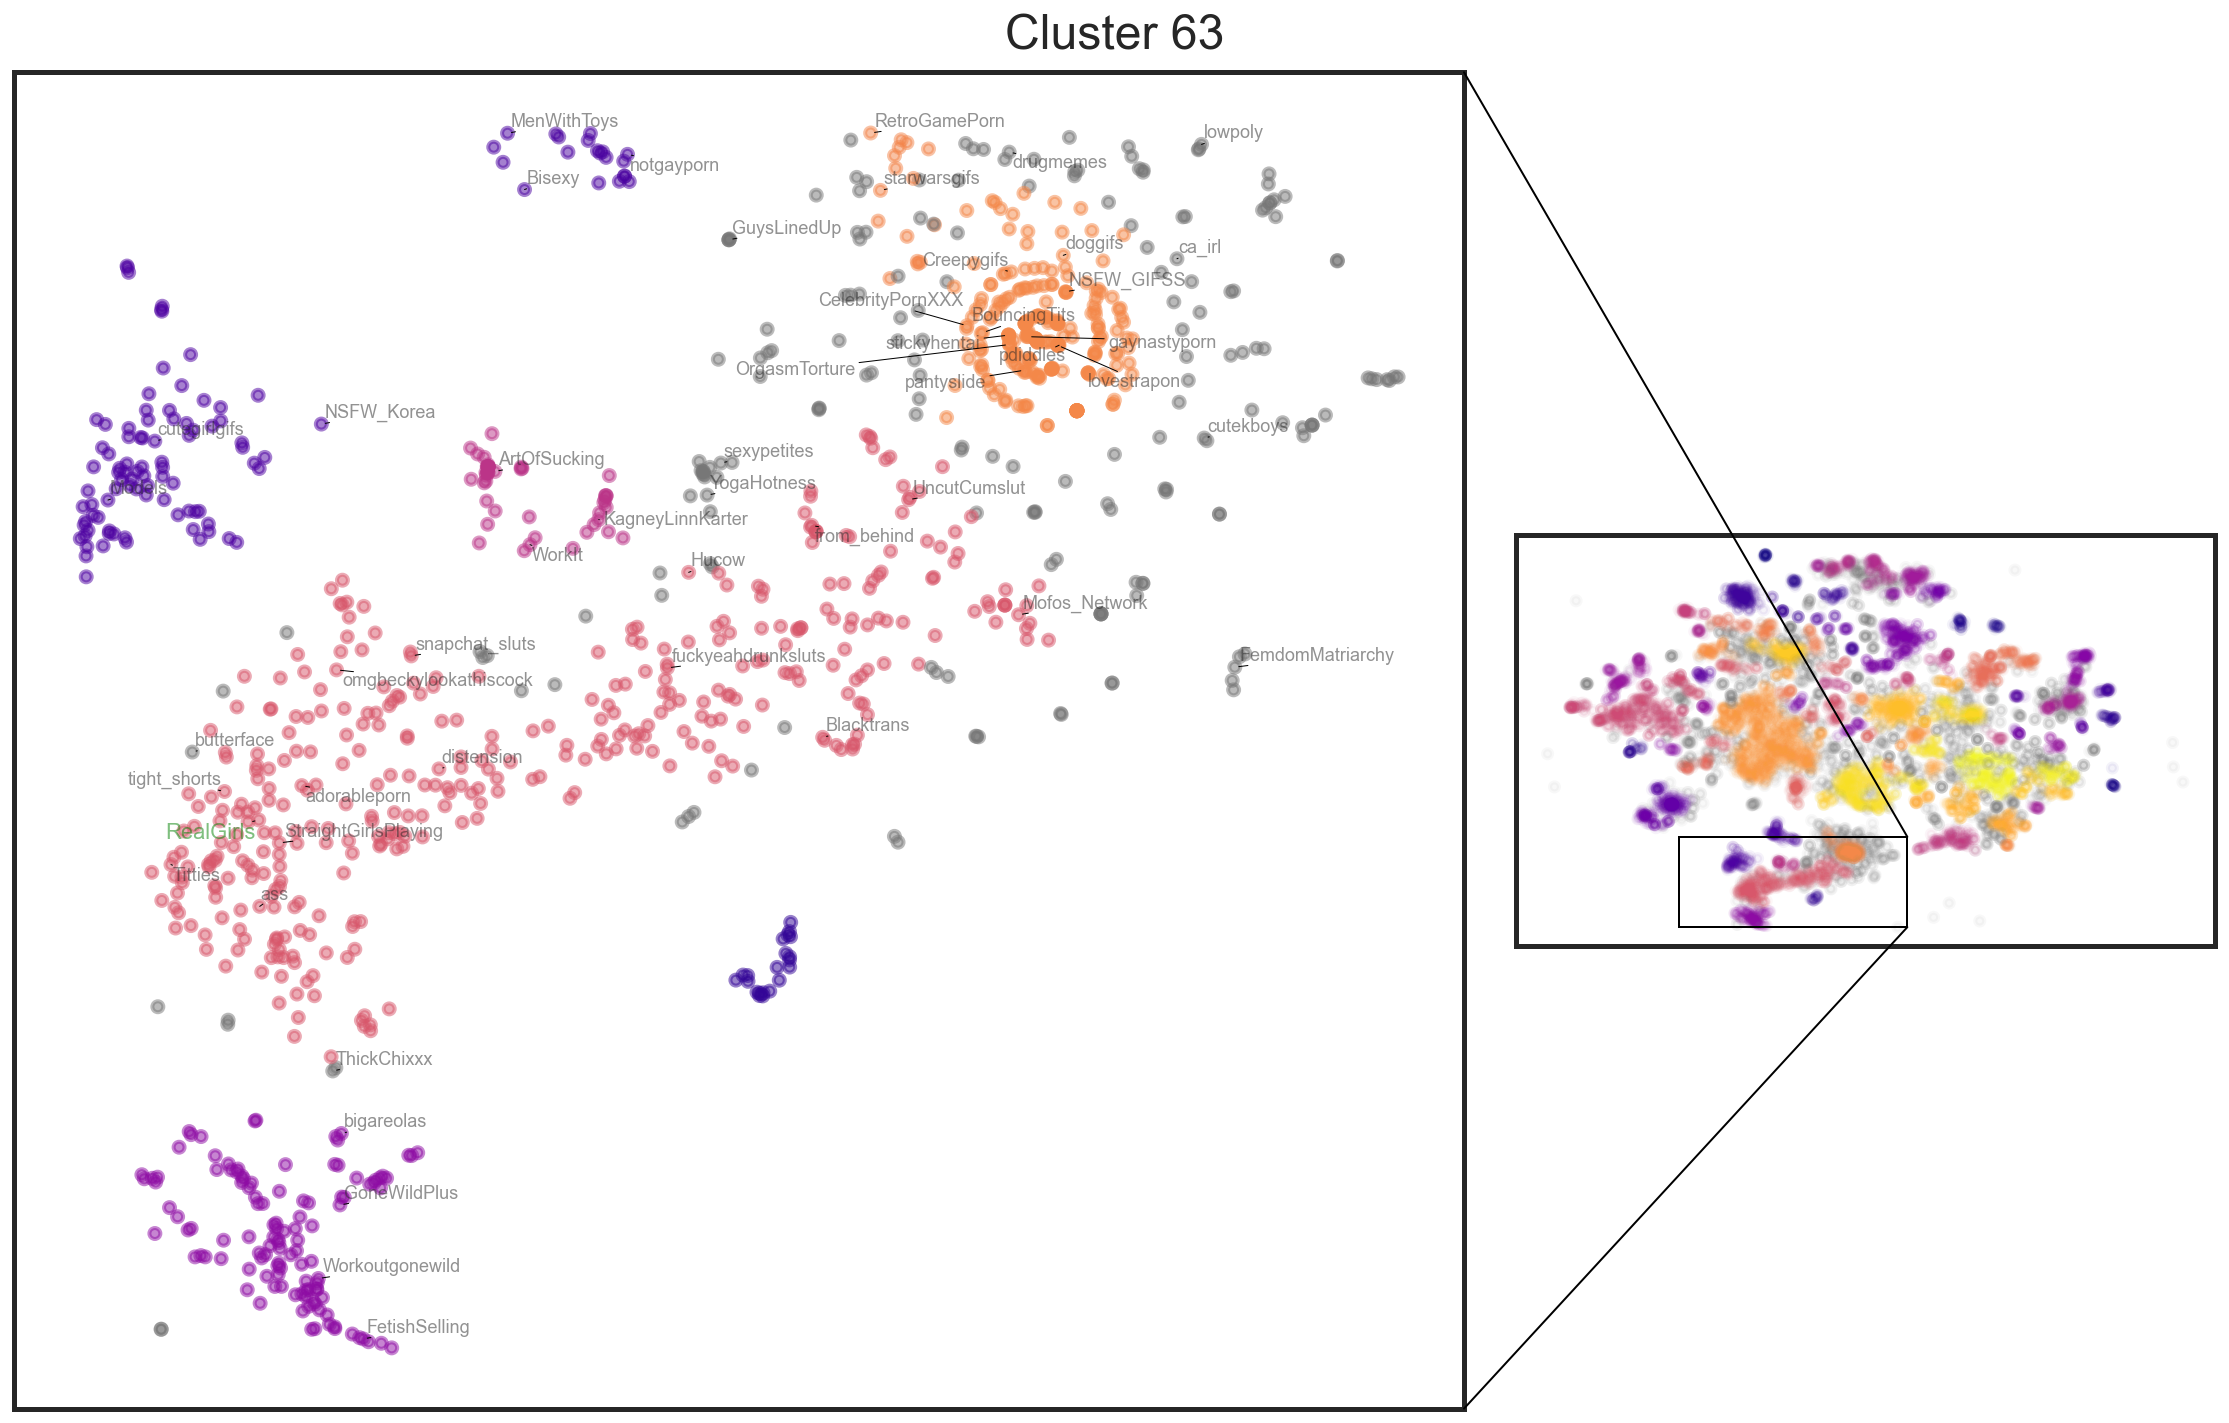

In [47]:
plot_cluster_by_id(subreddit_map_df, 63)

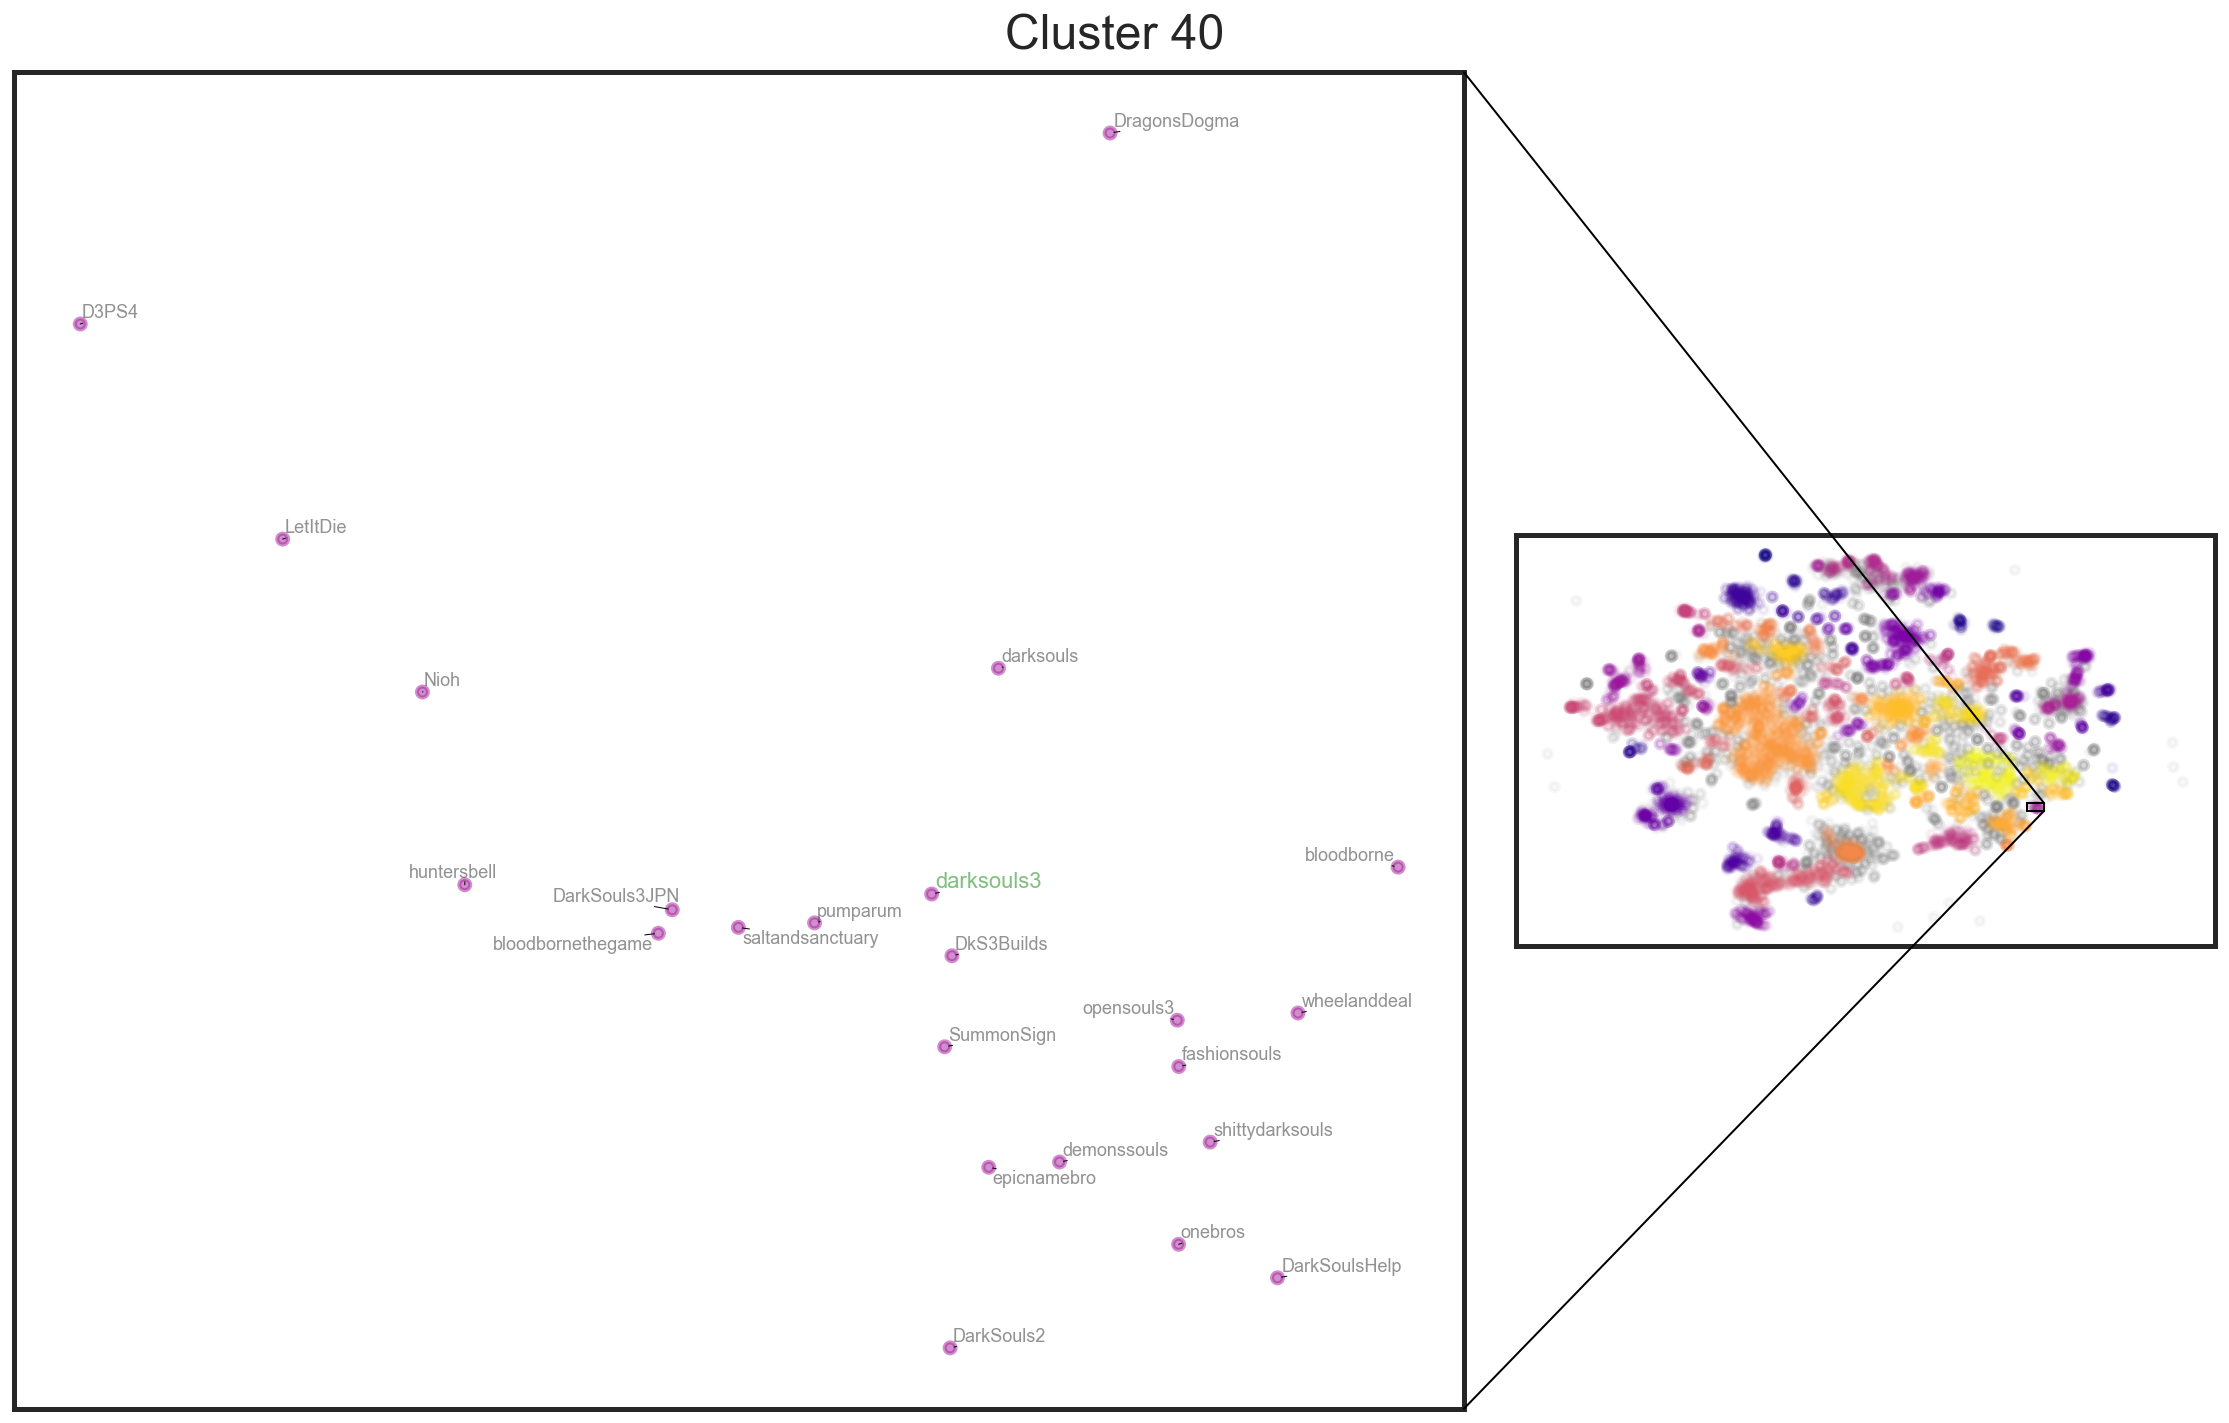

In [48]:
plot_cluster_by_id(subreddit_map_df, 40)